In [2]:
###import packages###
import pandas as pd
import collections
import timeit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.mlab as mlab
import statistics as stat
import random
import numpy.linalg
import numpy as np
import sys
#from pyswarm import pso
from scipy.optimize import minimize
elapsed_time = timeit.default_timer()

In [3]:
from sklearn import cluster
import seaborn as sns
sns.set()

In [4]:
def get_reactors(reac):
    reac_split = reac.split(' ')
    reactors = []
    for k in reac_split:
        if k != '&' and k!= '=>':
            reactors.append(k)
    return reactors[:-1]


def Hill(reactor, n, EC50):
    B = (EC50**n-1)/(2*EC50**n-1)
    C = (B-1)**(1/n)
    
   
    if reactor[0] == '!':
        m = max(globals()['{}'.format(reactor[1:])],0)
        return (1-B**m**n/(C**n + m**n))
        #return (1-B*m*globals()['{}'.format(reactor[1:])]**n/(C**n + m*globals()['{}'.format(reactor[1:])]**n))
        
    else:
        m1 = max(globals()['{}'.format(reactor)],0)
        return B*m1**n/(C**n + m1**n)
        
    #return B*m1*globals()['{}'.format(reactor)]**n/(C**n + m1*globals()['{}'.format(reactor)]**n)


def OR(reaction_list):
    tera = (-1)**(len(reaction_list)+1)
    for k in reaction_list:
        weight, n, EC50 = reaction_list[k]
        final = weight
        for j in get_reactors(k):
            final *= Hill(j, n, EC50)
        tera *= (final-1)
    tera +=1
    return tera

In [5]:
def inte(state,t,inpu,reaction_dict):
    for i in range(len(node_ID)):
        globals()['{}'.format(node_ID[i])] = state[i]
    for i in range(len(node_ID)):
        if node_ID[i] == 'ResistanceExercise':
            globals()['{}'.format('ResistanceExercised')] = (inpu*Ymax[i] - globals()['{}'.format('ResistanceExercise')])/tau[i] #0 - 0.47*log(2)*2**(-t/60)/60
        elif node_ID[i] == 'EnduranceExercise':
            globals()['{}'.format('EnduranceExercised')] = (inpu*Ymax[i] - globals()['{}'.format('EnduranceExercise')])/tau[i] #0 - 0.47*log(2)*2**(-t/60)/60 
        elif len(reaction_dict[node_ID[i]]) == 1:
            reactors = get_reactors(list(reaction_dict[node_ID[i]].keys())[0])
            weight, n, EC50 = reaction_dict[node_ID[i]][list(reaction_dict[node_ID[i]].keys())[0]]
            TF = 1
            for j in reactors:
                TF *= Hill(j, n, EC50)
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*weight*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
        else:
            TF = OR(reaction_dict[node_ID[i]])
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
    return [globals()['{}'.format(k+ 'd')] for k in node_ID]


In [6]:
def hill_simulation(inpu_HI, t, state0, reaction_dict):
    yHill_ss = odeint(inte, state0, t, args = (inpu_HI, reaction_dict))
    return yHill_ss

In [7]:
###################-------------------------------###################
###################----------Loading Data---------###################
###################-------------------------------###################

reaction_network = 'time_RE_EEw_phenotypes5.3.23-2.xlsx'

reactions = pd.read_excel(reaction_network, sheet_name = 1, skiprows = 1, header = 0)
species = pd.read_excel(reaction_network, sheet_name = 0, skiprows = 1, header = 0)

pmid = reactions['PMID'].tolist()
reactions = reactions[['rule', 'weight', 'n', 'EC50']]
species = species[['ID', 'Yinit', 'Ymax', 'tau']]
node_ID = species['ID'].tolist()
Yinit = species['Yinit'].tolist()
Ymax = species['Ymax'].tolist()
tau = species['tau'].tolist()

reaction_dict = collections.defaultdict(dict)
original_reaction_dict = collections.defaultdict(dict)
for k in range(len(reactions)):
    node = reactions.loc[k, 'rule'].split(' ')
    reaction_dict[node[-1]][reactions.loc[k, 'rule']] = reactions.loc[k, ['weight', 'n', 'EC50']].tolist()
    original_reaction_dict[node[-1]][reactions.loc[k, 'rule']] = reactions.loc[k, ['weight', 'n', 'EC50']].tolist()


species_dict = dict()
for k in range(len(species)):
    #lis = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()
    species_dict[species.loc[k, 'ID']] = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()

state0 = []
for k in range(len(node_ID)):
    state0.append(Yinit[k])  #solve_ivp


In [8]:
# phenotype changes following acute exercise from steady state baseline

In [9]:
t15h = np.arange(0.0, 900.0, 0.1)

In [10]:
# simulate 15h w/ no exercise

Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 0
y15h_Hill = hill_simulation(1, t15h, state0, reaction_dict)

In [11]:
state15 = []
for k in range(len(node_ID)):
    state15.append(y15h_Hill[8999,k])  #solve_ivp



In [12]:
t45 = np.arange(0.0, 45.0, 0.1)

In [13]:
# 45 min resistance exercise, starting at ss baseline

Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 0
y45_Hill_testR = hill_simulation(1, t45, state15, reaction_dict)
Ymax[node_ID.index('EnduranceExercise')] = 1
Ymax[node_ID.index('ResistanceExercise')] = 1

In [14]:
# 45 min endurance exercise, starting at ss baseline

Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 1
y45_Hill_testE = hill_simulation(1, t45, state15, reaction_dict)
Ymax[node_ID.index('EnduranceExercise')] = 1
Ymax[node_ID.index('ResistanceExercise')] = 1

In [15]:
state1545R = []
for k in range(len(node_ID)):
    state1545R.append(y45_Hill_testR[449,k])  #solve_ivp
    
    
    state1545E = []
for k in range(len(node_ID)):
    state1545E.append(y45_Hill_testE[449,k])  #solve_ivp

In [16]:
# 15h w/ no exercise, starting w/ activation values from immediately after 45 min exercise

Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 0
y30h45_HillR = hill_simulation(1, t15h, state1545R, reaction_dict)
y30h45_HillE = hill_simulation(1, t15h, state1545E, reaction_dict)

In [17]:
# concatenate 15h no exercise, 45 min exercise, 15h no exercise 
y3045R = numpy.concatenate((y15h_Hill, y45_Hill_testR,y30h45_HillR), axis = 0)
y3045E = numpy.concatenate((y15h_Hill, y45_Hill_testE,y30h45_HillE), axis = 0)
t3045=np.arange(0.0, 1845.0, 0.1)
tgraph = np.arange(0.0, 945.0, 0.1)

In [18]:
# 45 min resistance exercise, starting at ee baseline

Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 0
y45_Hill_testER = hill_simulation(1, t45, state1545E, reaction_dict)
Ymax[node_ID.index('EnduranceExercise')] = 1
Ymax[node_ID.index('ResistanceExercise')] = 1

In [19]:
# 45 min endurance exercise, starting at re baseline

Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 1
y45_Hill_testRE = hill_simulation(1, t45, state1545R, reaction_dict)
Ymax[node_ID.index('EnduranceExercise')] = 1
Ymax[node_ID.index('ResistanceExercise')] = 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


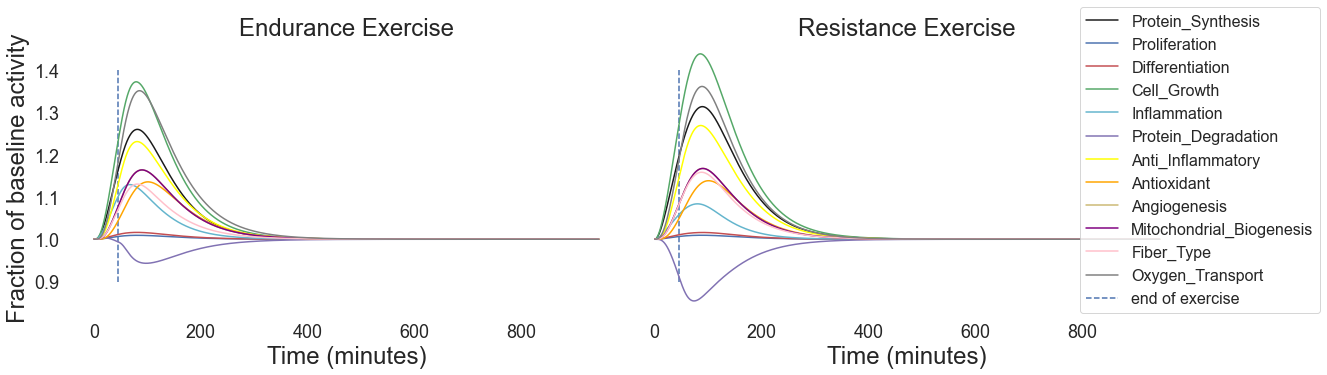

In [21]:




fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey= True,
                                    figsize=(20, 5))
fig.subplots_adjust(wspace=0.01)
#fig.supxlabel('Time (minutes)')

ax1.set_facecolor("white")
ax2.set_facecolor("white")

ax1.plot(tgraph, y3045E[9000:18950,109]/y3045E[9001,109], label = node_ID[109], color = 'k')

ax1.plot(tgraph, y3045E[9000:18950,110]/y3045E[9001,110], label = node_ID[110], color = 'b')

ax1.plot(tgraph, y3045E[9000:18950,111]/y3045E[9001,111], label = node_ID[111], color = 'r')

ax1.plot(tgraph, y3045E[9000:18950,112]/y3045E[9001,112], label = node_ID[112], color = 'g')
ax1.plot(tgraph, y3045E[9000:18950,113]/y3045E[9001,113], label = node_ID[113], color = 'c')

ax1.plot(tgraph, y3045E[9000:18950,114]/y3045E[9001,114], label = node_ID[114], color = 'm')

ax1.plot(tgraph, y3045E[9000:18950,115]/y3045E[9001,115], label = node_ID[115], color = 'yellow')

ax1.plot(tgraph, y3045E[9000:18950,116]/y3045E[9001,116], label = node_ID[116], color = 'orange')

ax1.plot(tgraph, y3045E[9000:18950,117]/y3045E[9001,117], label = node_ID[117], color = 'y')

ax1.plot(tgraph, y3045E[9000:18950,118]/y3045E[9001,118], label = node_ID[118], color = 'purple')

ax1.plot(tgraph, y3045E[9000:18950,119]/y3045E[9001,119], label = node_ID[119], color = 'pink')

ax1.plot(tgraph, y3045E[9000:18950,120]/y3045E[9001,120], label = node_ID[120], color = 'gray')

#ax1.annotate('end of exercise', (100,0), xytext=(100,-25), xycoords='axes points', textcoords='axes points', arrowprops= dict(facecolor ='k', width = 15, headlength = 15), fontsize = 20)
ax2.plot(tgraph, y3045R[9000:18950,109]/y3045R[9001,109], color = 'k')
ax2.plot(tgraph, y3045R[9000:18950,110]/y3045R[9001,110],  color = 'b')
ax2.plot(tgraph, y3045R[9000:18950,111]/y3045R[9001,111], color = 'r')
ax2.plot(tgraph, y3045R[9000:18950,112]/y3045R[9001,112],  color = 'g')
ax2.plot(tgraph, y3045R[9000:18950,113]/y3045R[9001,113], color = 'c')
ax2.plot(tgraph, y3045R[9000:18950,114]/y3045R[9001,114],  color = 'm')
ax2.plot(tgraph, y3045R[9000:18950,115]/y3045R[9001,115],  color = 'yellow')
ax2.plot(tgraph, y3045R[9000:18950,116]/ y3045R[9001,116],  color = 'orange')
ax2.plot(tgraph, y3045R[9000:18950,117]/y3045R[9001,117],  color = 'y')
ax2.plot(tgraph, y3045R[9000:18950,118]/y3045R[9001,118], color = 'purple')
ax2.plot(tgraph, y3045R[9000:18950,119]/y3045R[9001,119],  color = 'pink')
ax2.plot(tgraph, y3045R[9000:18950,120]/y3045R[9001,120],  color = 'gray')

ax1.set_title('Endurance Exercise', fontsize=24)
ax2.set_title('Resistance Exercise',fontsize=24)
ax1.vlines(x = 45,ymin = 0.9, ymax= 1.4, linestyles='dashed', label = 'end of exercise')
ax2.vlines(x = 45,ymin = 0.9, ymax= 1.4, linestyles='dashed')
#ax1.set_xticklabels(['0','200','400','600','800'],fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
#ax2.legend(loc = 1,fontsize=16)
ax1.set_xlabel('Time (minutes)', fontsize = 24)
ax2.set_xlabel('Time (minutes)', fontsize = 24)
ax1.set_ylabel('Fraction of baseline activity', fontsize = 24)
fig.legend(fontsize=16, facecolor='white')


plt.savefig('fig2a_timecourse', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


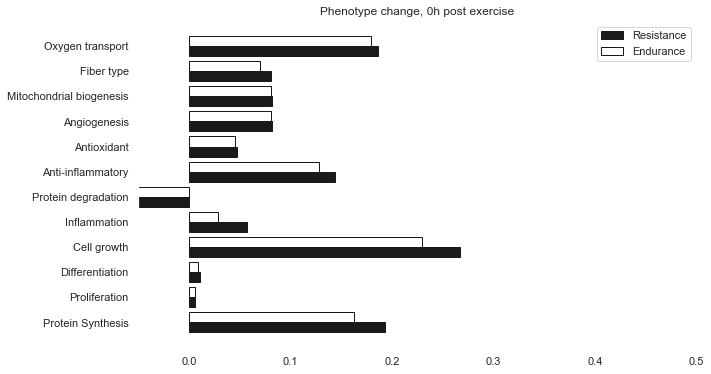

In [216]:
plt.figure(figsize=(10,6))
ax = plt.gca()
ax.set_facecolor("white")

prsynth_ss = y3045R[8990,109]
proliferation_ss = y3045R[8990,110]
Differentiation_ss = y3045R[8990,111]
Cell_Growth_ss = y3045R[8990,112]
Inflammation_ss = y3045R[8990,113]
Protein_Degradation_ss = y3045R[8990,114]
Anti_Inflammatory_ss = y3045R[8990,115]
Antioxidant_ss = y3045R[8990,116]
Angiogenesis_ss = y3045R[8990,117]
Mitochondrial_Biogenesis_ss = y3045R[8990,118]
Fiber_Type_ss = y3045R[8990,119]
Oxygen_Transport_ss = y3045R[8990,120]

prsynth0 = (y3045R[9450,109])/prsynth_ss-1
proliferation0 = (y3045R[9450,110])/proliferation_ss-1
Differentiation0 = (y3045R[9450,111])/Differentiation_ss-1
Cell_Growth0 = (y3045R[9450,112])/Cell_Growth_ss-1
Inflammation0 = (y3045R[9450,113])/Inflammation_ss-1
Protein_Degradation0 = (y3045R[9450,114])/Protein_Degradation_ss-1
Anti_Inflammatory0 = (y3045R[9450,115])/Anti_Inflammatory_ss-1
Antioxidant0 = (y3045R[9450,116])/Antioxidant_ss-1
Angiogenesis0 = (y3045R[9450,117])/Angiogenesis_ss-1
Mitochondrial_Biogenesis0 = (y3045R[9450,118])/Mitochondrial_Biogenesis_ss-1
Fiber_Type0 = (y3045R[9450,119])/Fiber_Type_ss-1
Oxygen_Transport0 = (y3045R[9450,120])/Oxygen_Transport_ss-1

prsynth0e = (y3045E[9450,109])/prsynth_ss-1
proliferation0e = (y3045E[9450,110])/proliferation_ss-1
Differentiation0e = (y3045E[9450,111])/Differentiation_ss-1
Cell_Growth0e = (y3045E[9450,112])/Cell_Growth_ss-1
Inflammation0e = (y3045E[9450,113])/Inflammation_ss-1
Protein_Degradation0e = (y3045E[9450,114])/Protein_Degradation_ss-1
Anti_Inflammatory0e = (y3045E[9450,115])/Anti_Inflammatory_ss-1
Antioxidant0e = (y3045E[9450,116])/Antioxidant_ss-1
Angiogenesis0e = (y3045E[9450,117])/Angiogenesis_ss-1
Mitochondrial_Biogenesis0e = (y3045E[9450,118])/Mitochondrial_Biogenesis_ss-1
Fiber_Type0e = (y3045E[9450,119])/Fiber_Type_ss-1
Oxygen_Transport0e = (y3045E[9450,120])/Oxygen_Transport_ss-1

phenotypes = ['Protein Synthesis', 'Proliferation', 'Differentiation', 'Cell growth', 'Inflammation', 'Protein degradation', 'Anti-inflammatory', 'Antioxidant', 'Angiogenesis', 'Mitochondrial biogenesis', 'Fiber type', 'Oxygen transport']
phenotype_change0e = ([prsynth0e,proliferation0e,Differentiation0e,Cell_Growth0e,Inflammation0e,Protein_Degradation0e,Anti_Inflammatory0e,Antioxidant0e,Angiogenesis0e,Mitochondrial_Biogenesis0e,Fiber_Type0e,Oxygen_Transport0e])

y_axis= np.arange(len(phenotypes))

phenotype_change0 =([prsynth0,proliferation0,Differentiation0,Cell_Growth0,Inflammation0,Protein_Degradation0,Anti_Inflammatory0,Antioxidant0,Angiogenesis0,Mitochondrial_Biogenesis0,Fiber_Type0,Oxygen_Transport0])

plt.barh(y_axis-0.2, phenotype_change0,0.4, label = 'Resistance', edgecolor='k',color = 'k')
plt.barh(y_axis+0.2, phenotype_change0e,0.4, label = 'Endurance', edgecolor='k', color='None')

plt.yticks(y_axis, phenotypes)
plt.title('Phenotype change, 0h post exercise')
#plt.vlines(x = 0.025,ymin = -1, ymax= 12, linestyles='dashed')
#plt.xlim(-0.1,0.3)
plt.xlim(-0.05,0.5)
plt.legend(facecolor='white')
plt.savefig('fig2c_phenotype_bargraph_0_nocolor.eps', format='eps')
plt.show()

In [217]:
for i in node_ID:
    print( i, (y3045R[9450, node_ID.index(i)]-y3045R[9000,node_ID.index(i)]))

ResistanceExercise 1.0
EnduranceExercise 0.0
SAC 1.0
integrin 1.0
LPAR 0.6931289649537471
IGF1R 0.38231865044417473
TGFBR 0.7
TNFR1 0.5540885570310927
STARS 1.0
BMP 1.0
TNFa 0.7564516207729814
TGFB 1.0
Ca 0.77664443037978
Shc 0.2777312344145863
Crk 0.2777312344145863
smad2_3 0.3683521220607633
smad4 1.0890896423662385e-25
smad1_5_8 0.46935848976486083
smad6_7 0.1426914503394972
f_actin 0.5099632049006849
g_actin 0.0
RhoA 0.5238437061035662
C3 0.0
PA 1.0890896423662385e-25
MAP4K 0.422495671683191
MST1_2 -0.02973188219148047
SAV1 1.0890896423662385e-25
IRS1 0.21689929516386242
FAK 0.42016226566091197
ras 0.2730641642207149
LIMK1_2 0.24794479710580963
ROCK 0.3574270120754284
MOB1A_B 1.0890896423662385e-25
LATS1_2 -0.0951806865544525
NDR1_2 0.30057532471553194
raf 0.16372570052172203
PI3K 0.2640133849972469
CAMK 0.5158950000866594
p38 0.39853189716849136
JNK 0.45827319562499114
MEK 0.485971277138368
ERK1_2 0.43520630880279687
RSK 0.28499157529211133
cSrc 0.2783167815529643
TSC1_2 -0.217393

In [218]:
for i in node_ID:
    print( i, (y3045E[9450, node_ID.index(i)]-y3045E[9000,node_ID.index(i)]))

ResistanceExercise 0.0
EnduranceExercise 1.0
SAC 1.0
integrin 0.0
LPAR -4.9116994516124254e-26
IGF1R 0.3811888490760013
TGFBR 0.0
TNFR1 0.10391473540235918
STARS 1.0
BMP 0.0
TNFa 0.13127773729887465
TGFB 0.0
Ca 0.6919884780882524
Shc 0.27720938302477177
Crk 0.27720938302477177
smad2_3 0.20784341706571563
smad4 1.0890896658737532e-25
smad1_5_8 0.0
smad6_7 0.12504845691382876
f_actin 0.4370621347319671
g_actin 0.0
RhoA 0.38800791068055374
C3 0.0
PA 1.0890896658737532e-25
MAP4K 0.057757672999388054
MST1_2 -0.041804564664642566
SAV1 1.0890896658737532e-25
IRS1 0.21540131247855832
FAK 0.2358425615544526
ras 0.25366610177922044
LIMK1_2 0.19425613388824564
ROCK 0.2762376226720642
MOB1A_B 1.0890896658737532e-25
LATS1_2 -0.12667779201918572
NDR1_2 0.023039938915563444
raf 0.1502071485159317
PI3K 0.43067355793174034
CAMK 0.46935848507140854
p38 0.4643339589920673
JNK 0.42556705815244356
MEK 0.4370068996355228
ERK1_2 0.4311472298428298
RSK 0.27340905431499046
cSrc 0.15024580773623414
TSC1_2 -0.13

In [22]:
# concurrent training comparison, values for these plots calculated below

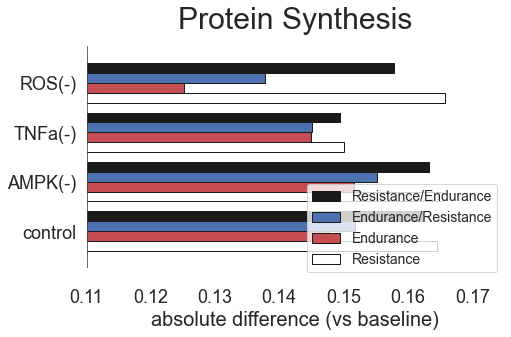

In [246]:
plt.figure(figsize=(7.5,4.5))
ax = plt.gca()
ax.set_facecolor("white")

#label = ['Resistance/Endurance','Endurance/Resistance', 'Endurance exercise only', 'Resistance exercise only' ]
label = ['control', 'AMPK(-)', 'TNFa(-)', 'ROS(-)']
#pr_synth = [0.1623,0.151744,0.14778, 0.16456] 
#pr_synth_ampk = [0.16331,0.15515075, 0.1516356,0.16533]
#pr_synth_tnfa = [0.14940116,0.1451747, 0.1449711,0.150136]
#pr_synth_ros = [0.157899,0.1377370,0.1251637,0.1657729]

re = [0.1623,0.16331,0.14940116,0.157899]
er = [0.151744,0.15515075,0.1451747,0.1377370]
e= [0.14778,0.1516356,0.1449711,0.1251637] 
r = [0.16456,0.16533,0.150136,0.1657729]
y_axis= np.arange(len(label))

#plt.barh(y_axis+0.3, pr_synth, 0.2, label = 'control', color = 'k',edgecolor='k')
#plt.barh(y_axis+0.1, pr_synth_ampk, 0.2, label = 'AMPK(-)', edgecolor='k', color='b')
#plt.barh(y_axis-0.1, pr_synth_tnfa, 0.2, label = 'TNFa(-)', edgecolor='k', color='r')
#plt.barh(y_axis-0.3, pr_synth_ros, 0.2, label = 'ROS(-)', edgecolor='k', color='None')

plt.barh(y_axis+0.3, re, 0.2, label = 'Resistance/Endurance', color = 'k',edgecolor='k')
plt.barh(y_axis+0.1, er, 0.2, label = 'Endurance/Resistance', edgecolor='k', color='b')
plt.barh(y_axis-0.1, e, 0.2, label = 'Endurance', edgecolor='k', color='r')
plt.barh(y_axis-0.3, r, 0.2, label = 'Resistance', edgecolor='k', color='None')

plt.yticks(y_axis, label,fontsize = 24)
#plt.xticks(np.arange(0.15, .05, 0.175))

plt.title('Protein Synthesis', fontsize=30)
plt.xlim(.11,.175)
plt.xlabel('absolute difference (vs baseline)', fontsize=20)
plt.legend(facecolor='white', fontsize=14, loc = 'lower right')
plt.vlines(x = .1101,ymin = -0.75, ymax= 3.75, linestyles='solid', color = 'k')

plt.savefig('fig5a_proteinsynth.jpg', format='jpg')
plt.tick_params(axis='both', which='major', labelsize=18)

In [23]:
t24htest = np.arange(0.0, 1485.0, 0.1)

Ymax[node_ID.index('ResistanceExercise')] = 0.1
Ymax[node_ID.index('EnduranceExercise')] = 0.1
y24h_Hill_test = hill_simulation(1, t24htest, state0, reaction_dict)
Ymax[node_ID.index('ResistanceExercise')] = 1

Ymax[node_ID.index('EnduranceExercise')] = 1

In [146]:
Ymax[node_ID.index('AMPK')] = .1 # set to 0.1 for AMPK knock down

In [196]:
Ymax[node_ID.index('TNFa')] = .1

In [212]:
Ymax[node_ID.index('ROS')] = .1

In [248]:
 # 45 min RE
Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 0
t45 = np.arange(0.0, 45.0, 0.1)


y45_HillR = hill_simulation(1, t45, state15, reaction_dict)

Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 1

In [249]:
state45R = []
for k in range(len(node_ID)):
    state45R.append(y45_HillR[449,k])  #solve_ivp



In [250]:
# 45 min EE
Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 1
t45 = np.arange(0.0, 45.0, 0.1)


y45_HillE = hill_simulation(1, t45, state15, reaction_dict)

Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 1

In [253]:
state45E = []
for k in range(len(node_ID)):
    state45E.append(y45_HillE[449,k])  #solve_ivp
    

In [254]:
# 90 min concurrent, w/ resistance first
t45 = np.arange(0.0, 45.0, 0.1)

Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 1

y45_HillRE = hill_simulation(1, t45, state45R, reaction_dict)

Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 1

In [255]:
state90RE = []
for k in range(len(node_ID)):
    state90RE.append(y45_HillRE[449,k])  #solve_ivp



In [256]:
# 90 min concurrent, w/ endurance first

Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 0

y45_HillER = hill_simulation(1, t45, state45E, reaction_dict)

Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 1

In [257]:
state90ER = []
for k in range(len(node_ID)):
    state90ER.append(y45_HillER[449,k])  #solve_ivp



In [258]:
t90 = np.arange(0.0, 90.0, 0.1)

In [262]:


Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 0

y_afterRE = hill_simulation(1, t90, state90RE, reaction_dict)

Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 1

In [263]:


Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 0

y_afterER = hill_simulation(1, t90, state90ER, reaction_dict)

Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 1

In [ ]:
# percent change after 90 min concurrent training, compared to 90 min baseline input

for i in node_ID:
    print( i, (y45_HillRE[449, node_ID.index(i)]-y15h_Hill[8999,node_ID.index(i)]))
    #print( i, 100*(y45_HillRE[449, node_ID.index(i)]-y15h_Hill[8999,node_ID.index(i)])/y15h_Hill[8999,node_ID.index(i)])

In [ ]:
# percent change after 90 min concurrent training, compared to 90 min baseline input

for i in node_ID:
    #print( i, 100*(y45_HillER[449, node_ID.index(i)]-y15h_Hill[8999,node_ID.index(i)])/y15h_Hill[8999,node_ID.index(i)])
    print(i, y45_HillER[449, node_ID.index(i)]-y15h_Hill[8999,node_ID.index(i)])

In [247]:
Ymax[node_ID.index('AMPK')] = 1 
Ymax[node_ID.index('TNFa')] = 1
Ymax[node_ID.index('NFkB')] = 1
Ymax[node_ID.index('ROS')] = 1

In [223]:
# 90 min resistance only


t90 = np.arange(0.0, 90.0, 0.1)

Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 0
y90_HillR = hill_simulation(1, t90, state15, reaction_dict)
Ymax[node_ID.index('EnduranceExercise')] = 1
Ymax[node_ID.index('ResistanceExercise')] = 1




In [224]:
# percent change after 90 min resistance, compared to 90 min of baseline (RE and EE both 0.1)
for i in node_ID:
    #print( i, 100*(y90_HillR[889, node_ID.index(i)]-y15h_Hill[8999,node_ID.index(i)])/y15h_Hill[8999,node_ID.index(i)])
    print(i,(y90_HillR[899,node_ID.index(i)]-y15h_Hill[8999,node_ID.index(i)]))

ResistanceExercise 1.0
EnduranceExercise 0.0
SAC 1.0
integrin 1.0
LPAR 0.6999239625950724
IGF1R 0.38720749285608475
TGFBR 0.7
TNFR1 0.5540885570310927
STARS 1.0
BMP 1.0
TNFa 0.7564516207729814
TGFB 1.0
Ca 0.8046043193505877
Shc 0.2942286080628442
Crk 0.2942286080628442
smad2_3 0.38029316126114276
smad4 1.1013113412297626e-25
smad1_5_8 0.5010920806858098
smad6_7 0.170461336888371
f_actin 0.5172897898355285
g_actin 0.0
RhoA 0.5331641559282524
C3 0.0
PA 1.1013113412297626e-25
MAP4K 0.42737645018695203
MST1_2 -0.045386252419270766
SAV1 1.1013113412297626e-25
IRS1 0.2326612778255397
FAK 0.43572301399808866
ras 0.2902413061893453
LIMK1_2 0.29719396581672297
ROCK 0.3821157137073158
MOB1A_B 1.1013113412297626e-25
LATS1_2 -0.1272454144958396
NDR1_2 0.3213012271610933
raf 0.19359026074315205
PI3K 0.2875834543375346
CAMK 0.5733802759176141
p38 0.44157056160269037
JNK 0.47123028432787595
MEK 0.5519778531462189
ERK1_2 0.4665452556467471
RSK 0.33291356497268637
cSrc 0.3065798197279496
TSC1_2 -0.3213

In [225]:
# 90 min EE only

Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 1
y90_HillE = hill_simulation(1, t90, state15, reaction_dict)
Ymax[node_ID.index('EnduranceExercise')] = 1
Ymax[node_ID.index('ResistanceExercise')] = 1

In [226]:
# percent change after 90 min resistance, compared to 90 min of baseline (RE and EE both 0.1)
for i in node_ID:
    print( i, (y90_HillE[889, node_ID.index(i)]-y15h_Hill[8999,node_ID.index(i)]))
   #print( i, 100*(y90_HillE[889, node_ID.index(i)]-y15h_Hill[8999,node_ID.index(i)])/y15h_Hill[8999,node_ID.index(i)])

ResistanceExercise 0.0
EnduranceExercise 1.0
SAC 1.0
integrin 0.0
LPAR -4.9116994516124254e-26
IGF1R 0.3853283113676553
TGFBR 0.0
TNFR1 0.1280649756150171
STARS 1.0
BMP 0.0
TNFa 0.16110421783256307
TGFB 0.0
Ca 0.6999016382020371
Shc 0.292953883679208
Crk 0.292953883679208
smad2_3 0.19632180264289123
smad4 1.1012969087279244e-25
smad1_5_8 0.0
smad6_7 0.14666610558134913
f_actin 0.44451360846440024
g_actin 0.0
RhoA 0.3868757025427567
C3 0.0
PA 1.1012969087279244e-25
MAP4K 0.09507898780217758
MST1_2 -0.05479210703976267
SAV1 1.1012969087279244e-25
IRS1 0.22901730179716095
FAK 0.26948905454392635
ras 0.2745291824831514
LIMK1_2 0.22841873907235805
ROCK 0.2888888287655389
MOB1A_B 1.1012969087279244e-25
LATS1_2 0.022071024599929823
NDR1_2 0.059163638577780966
raf 0.1836535278051437
PI3K 0.4514091453137016
CAMK 0.5010309067832731
p38 0.3053850245236558
JNK 0.3674006784583759
MEK 0.48941174522125447
ERK1_2 0.34883766095470436
RSK 0.25268705711990963
cSrc 0.19680886613976428
TSC1_2 -0.1014596771

In [270]:
# sensitivity analysis

In [271]:
t = np.arange(0.0, 45.0, 0.1)

Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 0
y240_Hill= hill_simulation(1, t, state0, reaction_dict)
Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 1

In [ ]:
Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 0
y240_Hillre= hill_simulation(1, t, state0, reaction_dict)
Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 1

In [ ]:
nodes1=['SAC', 'Ca', 'LPAR', 'LPA', 'Gai2','Ga12', 'IGF1R', 'IRS1','PI3K','Akt','HSP70','TNFR1', 'STARS', 'BMP', 'BMPR','TNFa', 'TGFB', 'integrin', 'JNK','f_actin', 'RhoA', 'ROCK', 'MAP4K', 'FAK', 'p38', 'ras', 'MEK', 'ERK1_2', 'RSK', 'IKK', 'SRF', 'YAP_TAZ', 'CREB', 'NFkB', 'IGF1', 'PGC_1a','PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'Gas', 'B_AR', 'ROS']
nodes2=['SAC', 'integrin', 'LPAR', 'IGF1R', 'TGFBR', 'TNFR1', 'STARS', 'BMP', 'TNFa', 'TGFB', 'Ca', 'Shc', 'Crk', 'smad2_3', 'smad4', 'smad1_5_8', 'smad6_7', 'f_actin', 'g_actin', 'RhoA', 'C3', 'PA', 'MAP4K', 'MST1_2', 'SAV1', 'IRS1', 'FAK', 'ras', 'LIMK1_2', 'ROCK', 'MOB1A_B', 'LATS1_2', 'NDR1_2', 'raf', 'PI3K', 'CAMK', 'p38', 'JNK', 'MEK', 'ERK1_2', 'RSK', 'cSrc', 'TSC1_2', 'Akt', 'Rheb', 'HSP70', 'IKK', 'mTOR', 'AMPK', 'SRF', 'YAP_TAZ', 'CREB', 'TCF_Elk1', 'S6Ks', 'FoxO', 'NFkB', 'alpha_actin', 'c_fos', 'c_jun', 'IGF1', 'IL4', 'MHCIIa', 'S6', 'eIF4B', 'eIF4E', 'MAFbx', 'MuRF1', 'TIF_IA', 'CTGF', 'Cyr61', 'ANKRD1', 'LPA', 'cofilin', 'Ga12', 'Gai2', 'myogenin', 'HDAC', 'GSK3B', 'BMPR', 'IL6', 'IL8', 'MCP1', 'PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'MEF2', 'PGC_1a', 'Gas', 'B_AR', 'ROS', 'CYC', 'VEGF_A', 'myoglobin', 'Nrf2', 'SOD', 'GPx', 'catalase']

matrixRE2 = np.zeros((44,99))
a = 0

for i in nodes1:
    Ymax[node_ID.index(i)] = 0.5
    Ymax[node_ID.index('ResistanceExercise')] = 1
    Ymax[node_ID.index('EnduranceExercise')] = 0
    b = 0
    y240_Hill_0re= hill_simulation(1, t, state0, reaction_dict)
    for j in nodes2:
        matrixRE2[a][b] = (y240_Hill_0re[-1, node_ID.index(j)]-y240_Hillre[-1, node_ID.index(j)])/0.5
        b = b+1
    Ymax[node_ID.index(i)] = 1
  
    a = a+1


Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 1

In [ ]:
absre2 = np.absolute(matrixRE2)
print (absre2.sum(axis=1))

In [ ]:
Ymax[node_ID.index('ResistanceExercise')] = 0
Ymax[node_ID.index('EnduranceExercise')] = 1
y240_Hillee= hill_simulation(1, t, state0, reaction_dict)
Ymax[node_ID.index('ResistanceExercise')] = 1
Ymax[node_ID.index('EnduranceExercise')] = 1

In [ ]:

nodes1=['SAC', 'Ca', 'LPAR', 'LPA', 'Gai2', 'Ga12', 'IGF1R', 'IRS1','PI3K','Akt','HSP70','TNFR1', 'STARS', 'BMP', 'BMPR','TNFa', 'TGFB', 'integrin', 'JNK','f_actin', 'RhoA', 'ROCK', 'MAP4K', 'FAK', 'p38', 'ras', 'MEK', 'ERK1_2', 'RSK', 'IKK', 'SRF', 'YAP_TAZ', 'CREB', 'NFkB', 'IGF1', 'PGC_1a','PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'Gas', 'B_AR', 'ROS']
nodes2=['SAC', 'integrin', 'LPAR', 'IGF1R', 'TGFBR', 'TNFR1', 'STARS', 'BMP', 'TNFa', 'TGFB', 'Ca', 'Shc', 'Crk', 'smad2_3', 'smad4', 'smad1_5_8', 'smad6_7', 'f_actin', 'g_actin', 'RhoA', 'C3', 'PA', 'MAP4K', 'MST1_2', 'SAV1', 'IRS1', 'FAK', 'ras', 'LIMK1_2', 'ROCK', 'MOB1A_B', 'LATS1_2', 'NDR1_2', 'raf', 'PI3K', 'CAMK', 'p38', 'JNK', 'MEK', 'ERK1_2', 'RSK', 'cSrc', 'TSC1_2', 'Akt', 'Rheb', 'HSP70', 'IKK', 'mTOR', 'AMPK', 'SRF', 'YAP_TAZ', 'CREB', 'TCF_Elk1', 'S6Ks', 'FoxO', 'NFkB', 'alpha_actin', 'c_fos', 'c_jun', 'IGF1', 'IL4', 'MHCIIa', 'S6', 'eIF4B', 'eIF4E', 'MAFbx', 'MuRF1', 'TIF_IA', 'CTGF', 'Cyr61', 'ANKRD1', 'LPA', 'cofilin', 'Ga12', 'Gai2', 'myogenin', 'HDAC', 'GSK3B', 'BMPR', 'IL6', 'IL8', 'MCP1', 'PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'MEF2', 'PGC_1a', 'Gas', 'B_AR', 'ROS', 'CYC', 'VEGF_A', 'myoglobin', 'Nrf2', 'SOD', 'GPx', 'catalase']

matrixEE2 = np.zeros((44,99))

a = 0

for i in nodes1:
    Ymax[node_ID.index(i)] = 0.5
    Ymax[node_ID.index('ResistanceExercise')] = 0
    Ymax[node_ID.index('EnduranceExercise')] = 1
    b = 0
    y240_Hill_0ee= hill_simulation(1, t, state0, reaction_dict)
    for j in nodes2:
        matrixEE2[a][b] = (y240_Hill_0ee[-1, node_ID.index(j)]-y240_Hillee[-1, node_ID.index(j)])/0.5
        b = b+1
    Ymax[node_ID.index(i)] = 1
  
    a = a+1
   

In [ ]:
absee2 = np.absolute(matrixEE2)

print(absee2.sum(axis=1))

In [ ]:
print(matrixRE2)

In [ ]:
print(matrixEE2)

In [22]:
import seaborn as sns
import pandas as pd

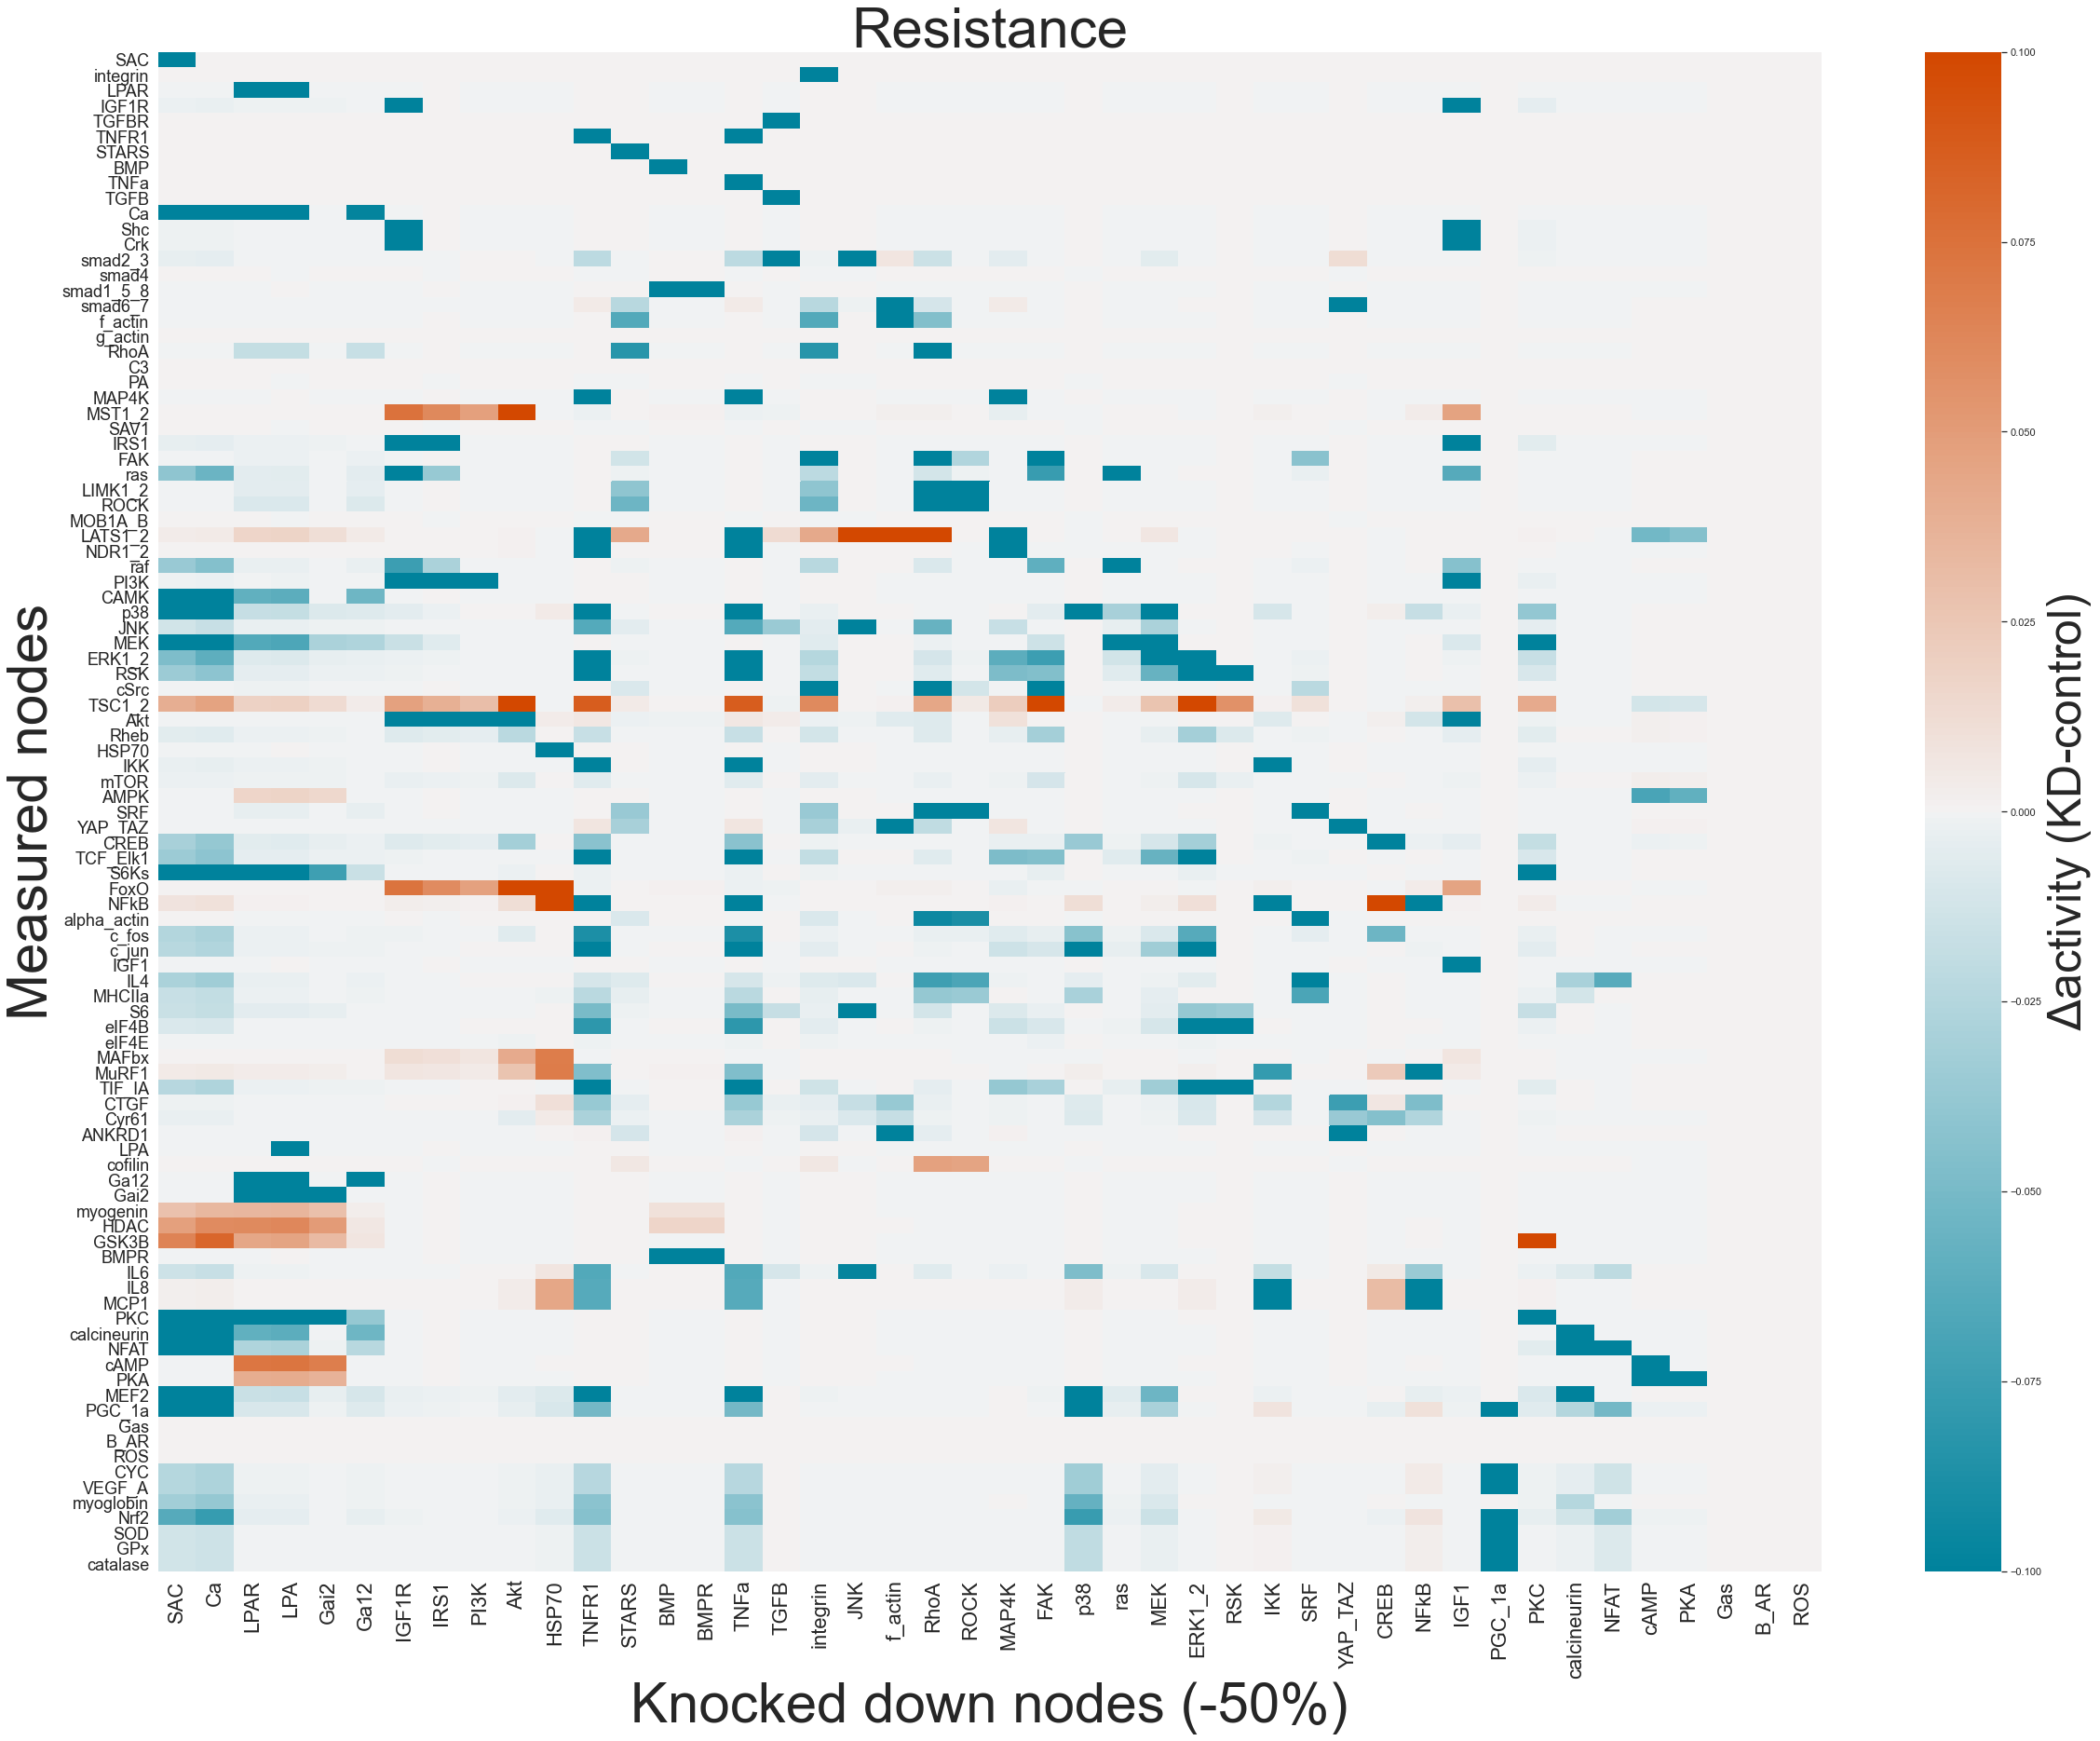

In [24]:
x=['SAC', 'Ca', 'LPAR', 'LPA', 'Gai2', 'Ga12', 'IGF1R', 'IRS1','PI3K','Akt','HSP70','TNFR1', 'STARS', 'BMP', 'BMPR','TNFa', 'TGFB', 'integrin', 'JNK','f_actin', 'RhoA', 'ROCK', 'MAP4K', 'FAK', 'p38', 'ras', 'MEK', 'ERK1_2', 'RSK', 'IKK', 'SRF', 'YAP_TAZ', 'CREB', 'NFkB', 'IGF1', 'PGC_1a','PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'Gas', 'B_AR', 'ROS']
y=['SAC', 'integrin', 'LPAR', 'IGF1R', 'TGFBR', 'TNFR1', 'STARS', 'BMP', 'TNFa', 'TGFB', 'Ca', 'Shc', 'Crk', 'smad2_3', 'smad4', 'smad1_5_8', 'smad6_7', 'f_actin', 'g_actin', 'RhoA', 'C3', 'PA', 'MAP4K', 'MST1_2', 'SAV1', 'IRS1', 'FAK', 'ras', 'LIMK1_2', 'ROCK', 'MOB1A_B', 'LATS1_2', 'NDR1_2', 'raf', 'PI3K', 'CAMK', 'p38', 'JNK', 'MEK', 'ERK1_2', 'RSK', 'cSrc', 'TSC1_2', 'Akt', 'Rheb', 'HSP70', 'IKK', 'mTOR', 'AMPK', 'SRF', 'YAP_TAZ', 'CREB', 'TCF_Elk1', 'S6Ks', 'FoxO', 'NFkB', 'alpha_actin', 'c_fos', 'c_jun', 'IGF1', 'IL4', 'MHCIIa', 'S6', 'eIF4B', 'eIF4E', 'MAFbx', 'MuRF1', 'TIF_IA', 'CTGF', 'Cyr61', 'ANKRD1', 'LPA', 'cofilin', 'Ga12', 'Gai2', 'myogenin', 'HDAC', 'GSK3B', 'BMPR', 'IL6', 'IL8', 'MCP1', 'PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'MEF2', 'PGC_1a', 'Gas', 'B_AR', 'ROS', 'CYC', 'VEGF_A', 'myoglobin', 'Nrf2', 'SOD', 'GPx', 'catalase']

matrixRE2_T = matrixRE2.transpose()
c = sns.diverging_palette(220, 20, s = 100, as_cmap=True)
p = sns.heatmap(matrixRE2_T, center=0, xticklabels =x, yticklabels= y, cmap = c, vmin = -0.1, vmax = 0.1, cbar_kws={'label': '$\Delta$activity (KD-control)'})
plt.tick_params(axis='x', labelsize=22, labelrotation=90)
plt.tick_params(axis='y', labelsize=18, labelrotation=0)
p.figure.axes[-1].yaxis.label.set_size(50)

sns.set(rc = {'figure.figsize':(40,30)}) 
p.set_ylabel('Measured nodes', fontsize = 60)
p.set_xlabel('Knocked down nodes (-50%)', fontsize = 60)
p.set_title("Resistance",fontsize = 60)
plt.savefig('sensitivityRE')

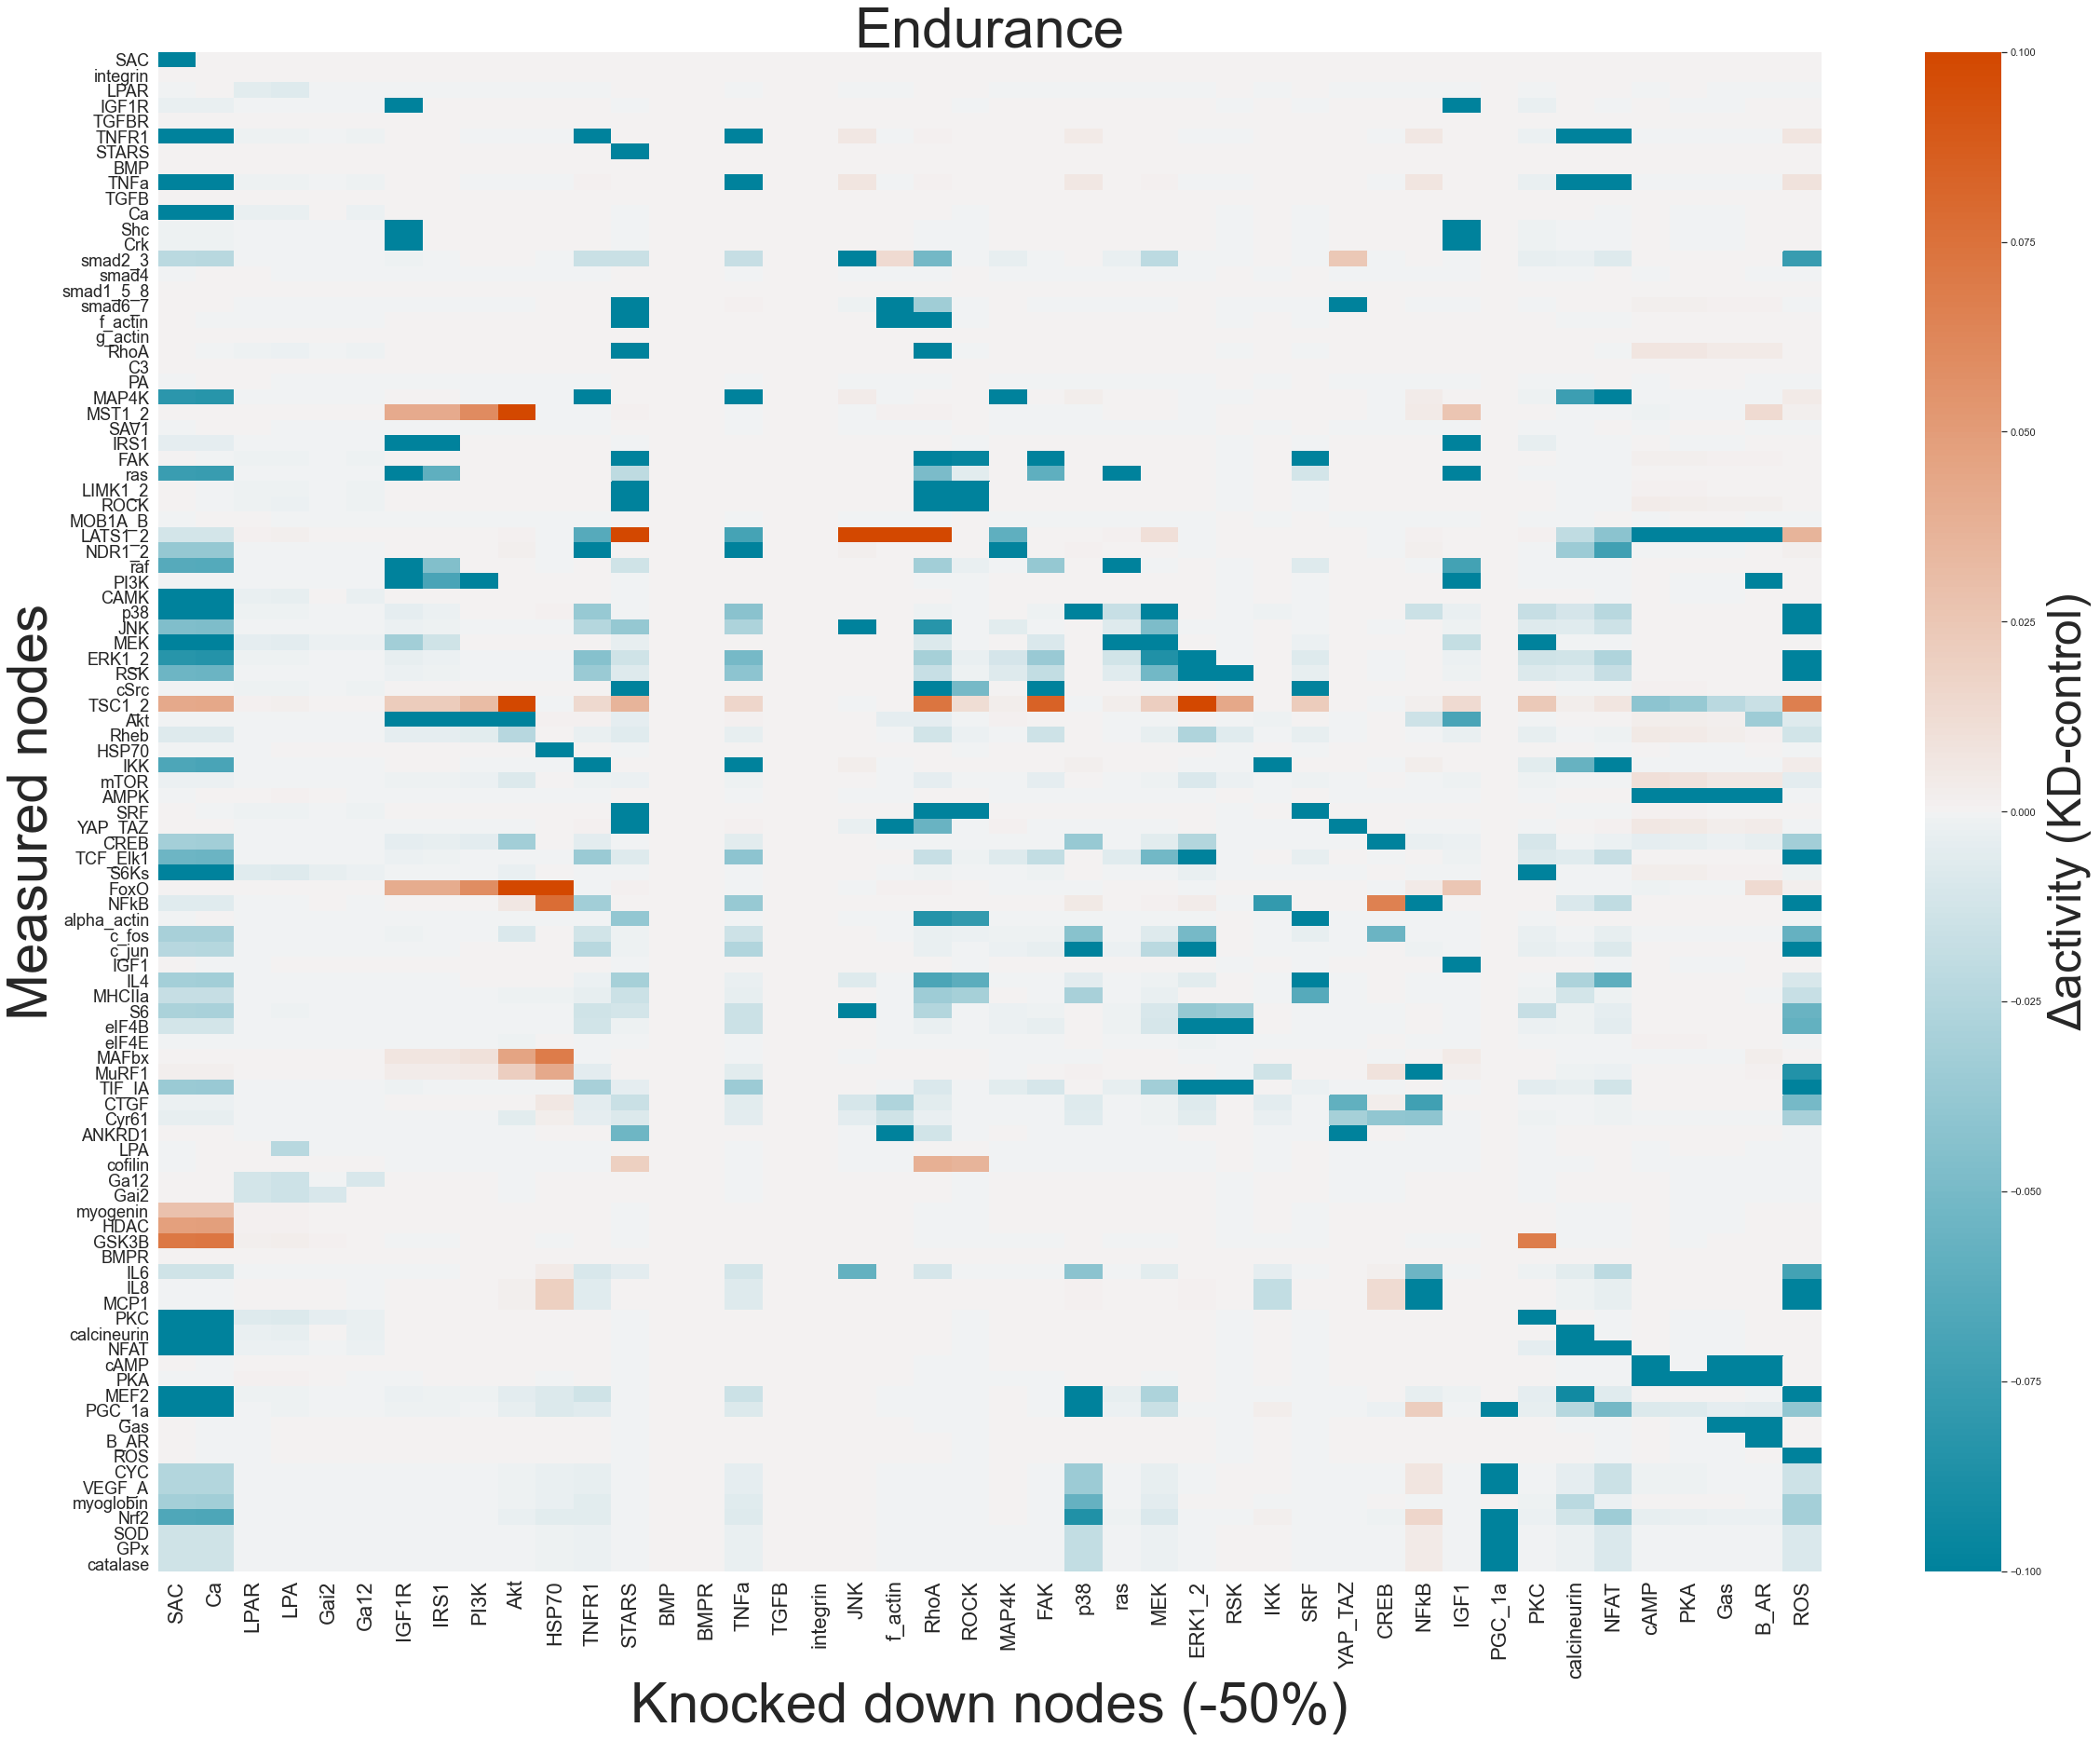

In [26]:
x=['SAC', 'Ca', 'LPAR', 'LPA', 'Gai2', 'Ga12', 'IGF1R', 'IRS1','PI3K','Akt','HSP70','TNFR1', 'STARS', 'BMP', 'BMPR','TNFa', 'TGFB', 'integrin', 'JNK','f_actin', 'RhoA', 'ROCK', 'MAP4K', 'FAK', 'p38', 'ras', 'MEK', 'ERK1_2', 'RSK', 'IKK', 'SRF', 'YAP_TAZ', 'CREB', 'NFkB', 'IGF1', 'PGC_1a','PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'Gas', 'B_AR', 'ROS']
y=['SAC', 'integrin', 'LPAR', 'IGF1R', 'TGFBR', 'TNFR1', 'STARS', 'BMP', 'TNFa', 'TGFB', 'Ca', 'Shc', 'Crk', 'smad2_3', 'smad4', 'smad1_5_8', 'smad6_7', 'f_actin', 'g_actin', 'RhoA', 'C3', 'PA', 'MAP4K', 'MST1_2', 'SAV1', 'IRS1', 'FAK', 'ras', 'LIMK1_2', 'ROCK', 'MOB1A_B', 'LATS1_2', 'NDR1_2', 'raf', 'PI3K', 'CAMK', 'p38', 'JNK', 'MEK', 'ERK1_2', 'RSK', 'cSrc', 'TSC1_2', 'Akt', 'Rheb', 'HSP70', 'IKK', 'mTOR', 'AMPK', 'SRF', 'YAP_TAZ', 'CREB', 'TCF_Elk1', 'S6Ks', 'FoxO', 'NFkB', 'alpha_actin', 'c_fos', 'c_jun', 'IGF1', 'IL4', 'MHCIIa', 'S6', 'eIF4B', 'eIF4E', 'MAFbx', 'MuRF1', 'TIF_IA', 'CTGF', 'Cyr61', 'ANKRD1', 'LPA', 'cofilin', 'Ga12', 'Gai2', 'myogenin', 'HDAC', 'GSK3B', 'BMPR', 'IL6', 'IL8', 'MCP1', 'PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'MEF2', 'PGC_1a', 'Gas', 'B_AR', 'ROS', 'CYC', 'VEGF_A', 'myoglobin', 'Nrf2', 'SOD', 'GPx', 'catalase']

matrixEE2_T = matrixEE2.transpose()
c = sns.diverging_palette(220, 20, s = 100, as_cmap=True)
p = sns.heatmap(matrixEE2_T, center=0, xticklabels =x, yticklabels= y, cmap = c, vmin = -0.1, vmax = 0.1, cbar_kws={'label': '$\Delta$activity (KD-control)'})
plt.tick_params(axis='x', labelsize=22, labelrotation=90)
plt.tick_params(axis='y', labelsize=18, labelrotation=0)
p.figure.axes[-1].yaxis.label.set_size(50)

sns.set(rc = {'figure.figsize':(40,30)}) 
p.set_ylabel('Measured nodes', fontsize = 60)
p.set_xlabel('Knocked down nodes (-50%)', fontsize = 60)
p.set_title("Endurance",fontsize = 60)
plt.savefig('sensitivityEE')

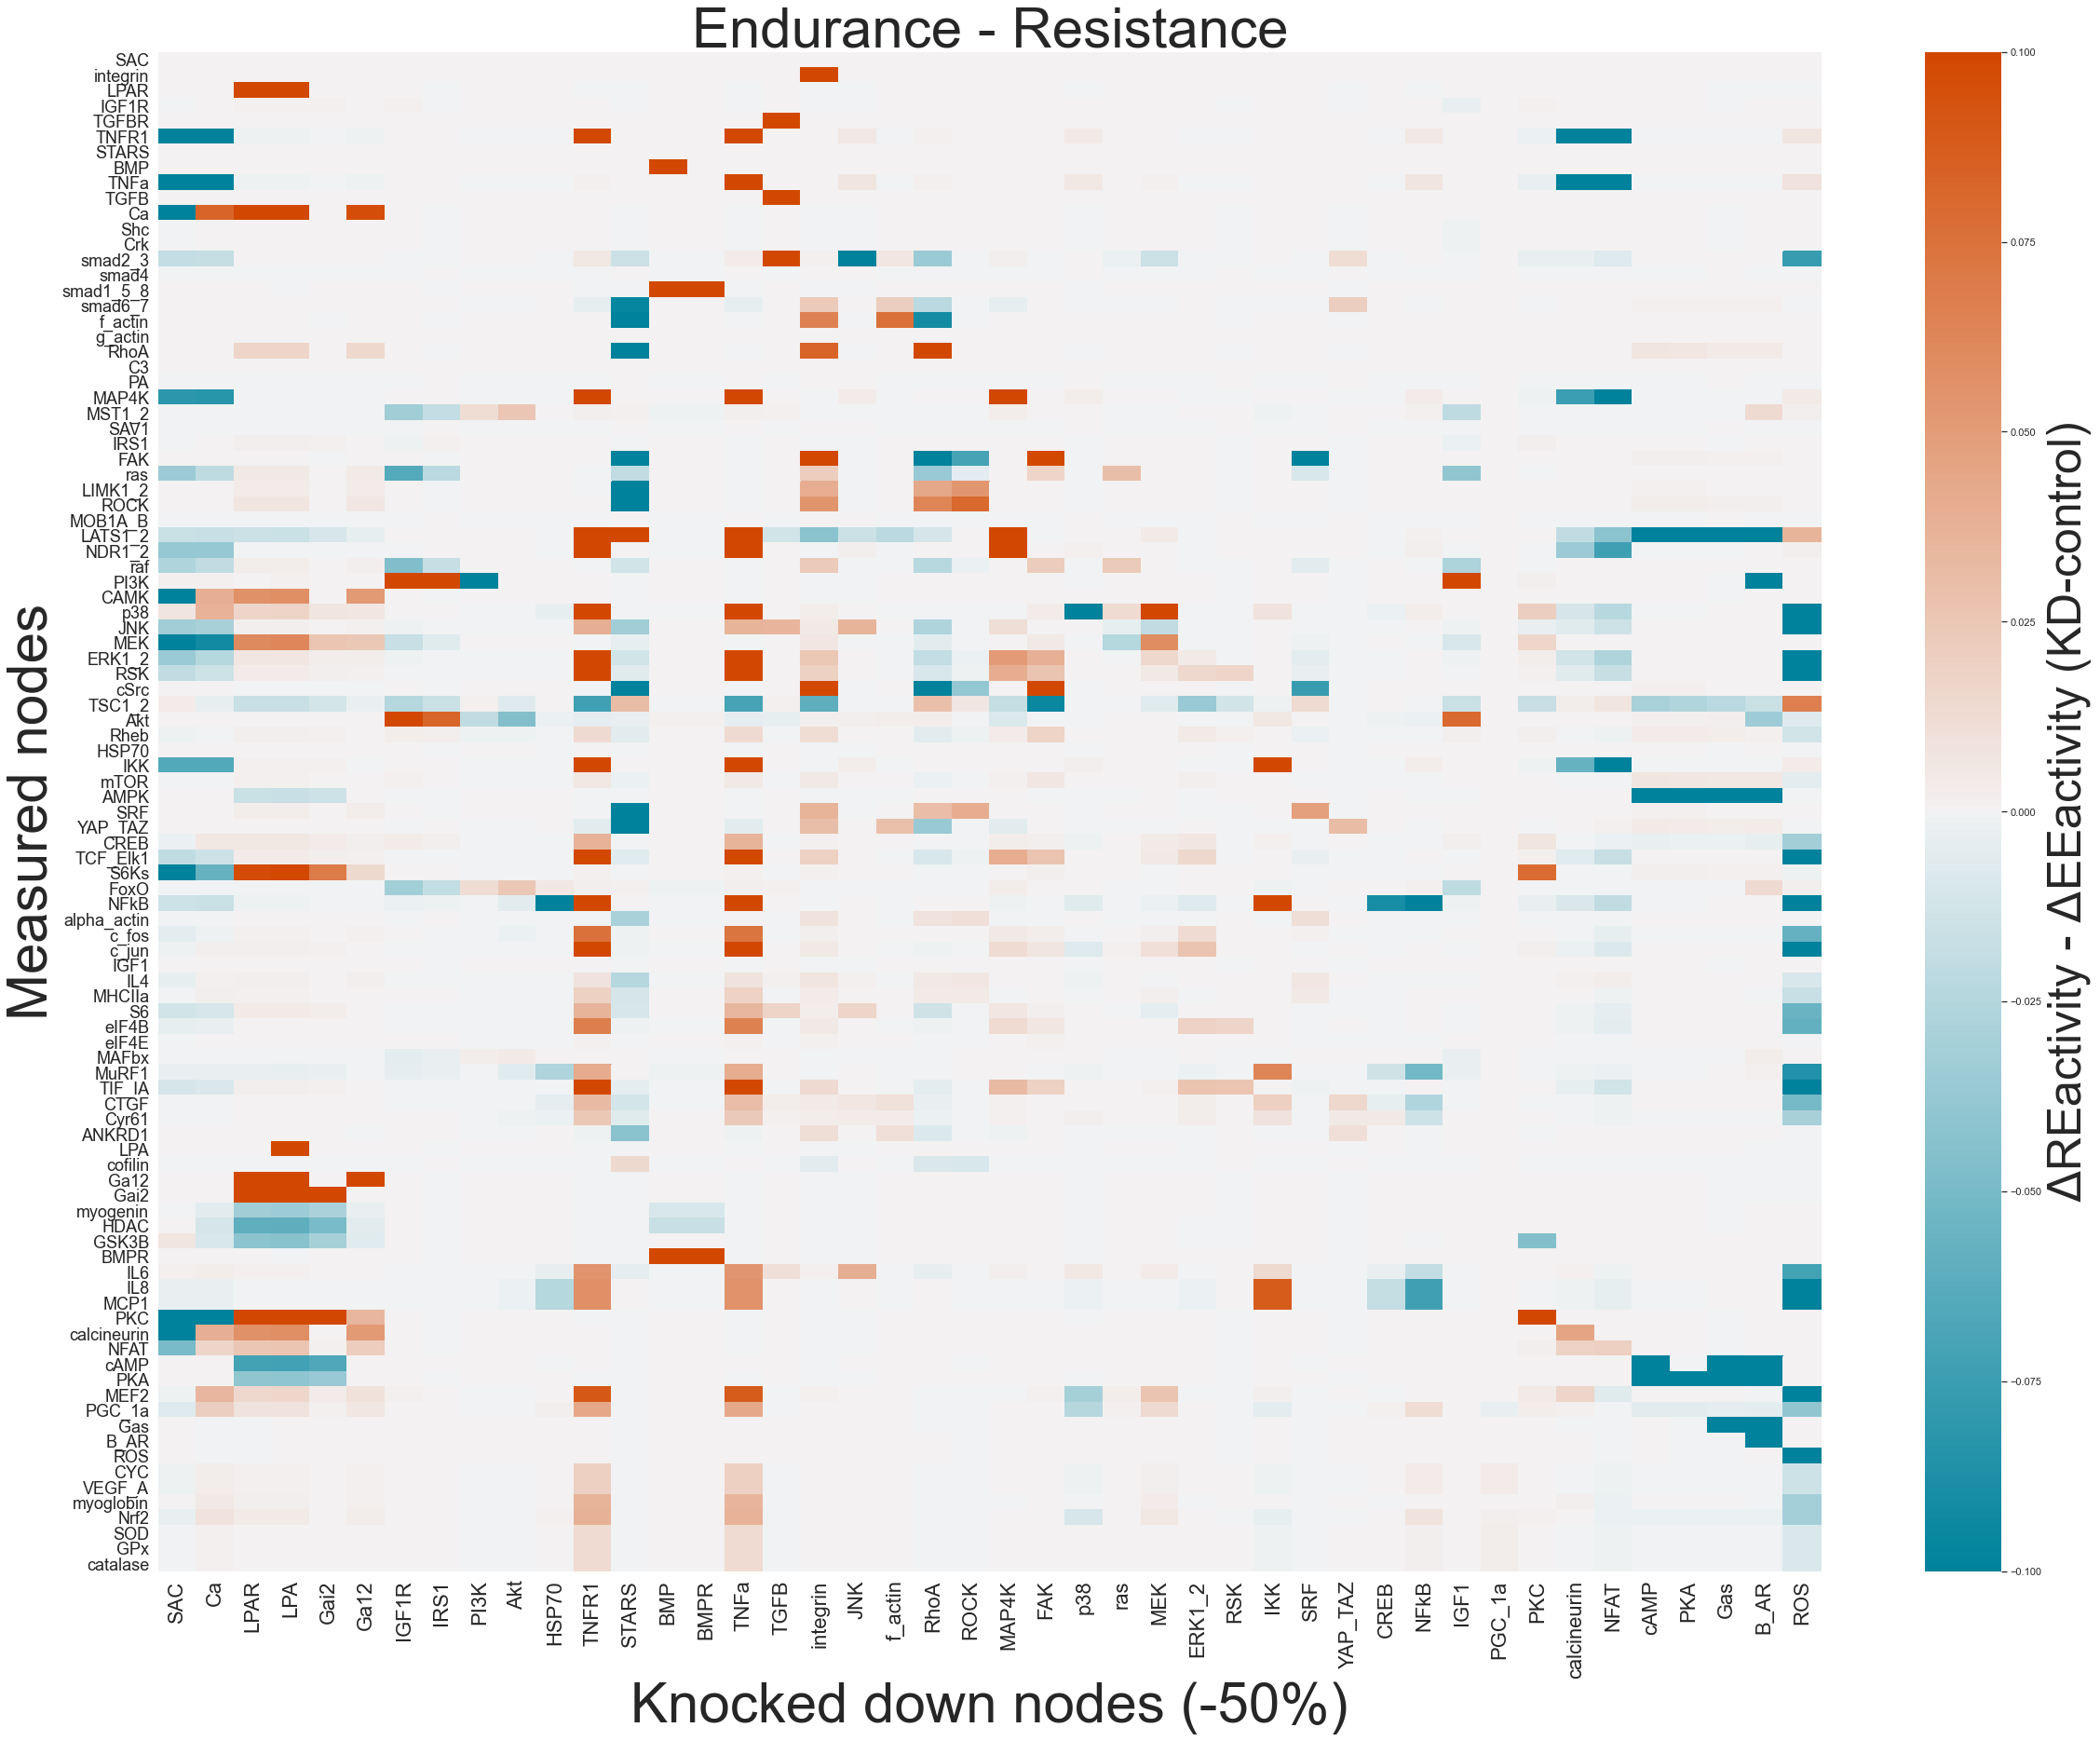

In [28]:
x=['SAC', 'Ca', 'LPAR', 'LPA', 'Gai2', 'Ga12', 'IGF1R', 'IRS1','PI3K','Akt','HSP70','TNFR1', 'STARS', 'BMP', 'BMPR','TNFa', 'TGFB', 'integrin', 'JNK','f_actin', 'RhoA', 'ROCK', 'MAP4K', 'FAK', 'p38', 'ras', 'MEK', 'ERK1_2', 'RSK', 'IKK', 'SRF', 'YAP_TAZ', 'CREB', 'NFkB', 'IGF1', 'PGC_1a','PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'Gas', 'B_AR', 'ROS']
y=['SAC', 'integrin', 'LPAR', 'IGF1R', 'TGFBR', 'TNFR1', 'STARS', 'BMP', 'TNFa', 'TGFB', 'Ca', 'Shc', 'Crk', 'smad2_3', 'smad4', 'smad1_5_8', 'smad6_7', 'f_actin', 'g_actin', 'RhoA', 'C3', 'PA', 'MAP4K', 'MST1_2', 'SAV1', 'IRS1', 'FAK', 'ras', 'LIMK1_2', 'ROCK', 'MOB1A_B', 'LATS1_2', 'NDR1_2', 'raf', 'PI3K', 'CAMK', 'p38', 'JNK', 'MEK', 'ERK1_2', 'RSK', 'cSrc', 'TSC1_2', 'Akt', 'Rheb', 'HSP70', 'IKK', 'mTOR', 'AMPK', 'SRF', 'YAP_TAZ', 'CREB', 'TCF_Elk1', 'S6Ks', 'FoxO', 'NFkB', 'alpha_actin', 'c_fos', 'c_jun', 'IGF1', 'IL4', 'MHCIIa', 'S6', 'eIF4B', 'eIF4E', 'MAFbx', 'MuRF1', 'TIF_IA', 'CTGF', 'Cyr61', 'ANKRD1', 'LPA', 'cofilin', 'Ga12', 'Gai2', 'myogenin', 'HDAC', 'GSK3B', 'BMPR', 'IL6', 'IL8', 'MCP1', 'PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'MEF2', 'PGC_1a', 'Gas', 'B_AR', 'ROS', 'CYC', 'VEGF_A', 'myoglobin', 'Nrf2', 'SOD', 'GPx', 'catalase']
matrixdf2 = np.zeros((44,99))
matrixdf2 = matrixEE2-matrixRE2
matrixdf2_T = matrixdf2.transpose()
c = sns.diverging_palette(220, 20, s = 100, as_cmap=True)
p = sns.heatmap(matrixdf2_T, center=0, xticklabels =x, yticklabels= y, cmap = c, vmin = -0.1, vmax = 0.1, cbar_kws={'label': '$\Delta$REactivity - $\Delta$EEactivity (KD-control)'})
plt.tick_params(axis='x', labelsize=22, labelrotation=90)
plt.tick_params(axis='y', labelsize=18, labelrotation=0)
p.figure.axes[-1].yaxis.label.set_size(50)

sns.set(rc = {'figure.figsize':(40,30)}) 
p.set_ylabel('Measured nodes', fontsize = 60)
p.set_xlabel('Knocked down nodes (-50%)', fontsize = 60)
p.set_title("Endurance - Resistance",fontsize = 60)
plt.savefig('sensitivityER')

In [125]:
nodes2=['SAC', 'integrin', 'LPAR', 'IGF1R', 'TGFBR', 'TNFR1', 'STARS', 'BMP', 'TNFa', 'TGFB', 'Ca', 'Shc', 'Crk', 'smad2_3', 'smad4', 'smad1_5_8', 'smad6_7', 'f_actin', 'g_actin', 'RhoA', 'C3', 'PA', 'MAP4K', 'MST1_2', 'SAV1', 'IRS1', 'FAK', 'ras', 'LIMK1_2', 'ROCK', 'MOB1A_B', 'LATS1_2', 'NDR1_2', 'raf', 'PI3K', 'CAMK', 'p38', 'JNK', 'MEK', 'ERK1_2', 'RSK', 'cSrc', 'TSC1_2', 'Akt', 'Rheb', 'HSP70', 'IKK', 'mTOR', 'AMPK', 'SRF', 'YAP_TAZ', 'CREB', 'TCF_Elk1', 'S6Ks', 'FoxO', 'NFkB', 'alpha_actin', 'c_fos', 'c_jun', 'IGF1', 'IL4', 'MHCIIa', 'S6', 'eIF4B', 'eIF4E', 'MAFbx', 'MuRF1', 'TIF_IA', 'CTGF', 'Cyr61', 'ANKRD1', 'LPA', 'cofilin', 'Ga12', 'Gai2', 'myogenin', 'HDAC', 'GSK3B', 'BMPR', 'IL6', 'IL8', 'MCP1', 'PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'MEF2', 'PGC_1a', 'Gas', 'B_AR', 'ROS', 'CYC', 'VEGF_A', 'myoglobin', 'Nrf2', 'SOD', 'GPx', 'catalase']
x=['SAC', 'Ca', 'LPAR', 'LPA', 'Gai2', 'Ga12', 'IGF1R', 'IRS1','PI3K','Akt','HSP70','TNFR1', 'STARS', 'BMP', 'BMPR','TNFa', 'TGFB', 'integrin', 'JNK','f_actin', 'RhoA', 'ROCK', 'MAP4K', 'FAK', 'p38', 'ras', 'MEK', 'ERK1_2', 'RSK', 'IKK', 'SRF', 'YAP_TAZ', 'CREB', 'NFkB', 'IGF1', 'PGC_1a','PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'Gas', 'B_AR', 'ROS']
nodes=['SAC',  'LPA', 'LPAR', 'B_AR',  'BMP', 'BMPR', 'IGF1', 'IGF1R', 'TGFB','TGFBR', 'TNFa',  'TNFR1', 'integrin','IRS1', 'FAK',  'cSrc', 'Ca', 'CAMK', 'PKC', 'calcineurin' , 'GSK3B', 'Shc', 'Crk', 'smad2_3', 'smad4', 'smad1_5_8', 'smad6_7', 'STARS', 'f_actin', 'g_actin', 'RhoA', 'LIMK1_2', 'ROCK', 'SRF', 'PA', 'MAP4K', 'MST1_2', 'SAV1', 'MOB1A_B', 'LATS1_2', 'NDR1_2', 'PI3K','Akt', 'TSC1_2', 'mTOR',  'Rheb', 'ras',  'raf',  'p38', 'JNK', 'MEK', 'ERK1_2', 'RSK', 'HSP70', 'IKK',  'HDAC', 'Ga12', 'Gai2', 'Gas', 'cAMP', 'AMPK', 'PKA',  'ROS','YAP_TAZ', 'myogenin',  'S6Ks', 'FoxO', 'NFkB',  'CREB', 'AP1', 'TIF_IA', 'TCF_Elk1','Nrf2', 'MEF2', 'PGC_1a', 'NFAT']
phenotypes=['Cell_Growth', 'Protein_Synthesis', 'Anti_Inflammatory', 'Fiber_Type', 'Antioxidant', 'Angiogenesis', 'Mitochondrial_Biogenesis',  'Oxygen_Transport', 'Differentiation', 'Proliferation', 'Inflammation', 'Protein_Degradation']



#nodes1=['SAC', 'Ca', 'LPAR', 'LPA', 'Gai2', 'Ga12', 'IGF1R', 'IRS1','PI3K','Akt','HSP70','TNFR1', 'STARS', 'BMP', 'BMPR','TNFa', 'TGFB', 'integrin', 'JNK','f_actin', 'RhoA', 'ROCK', 'MAP4K', 'FAK', 'p38', 'ras', 'MEK', 'ERK1_2', 'RSK', 'IKK', 'SRF', 'YAP_TAZ', 'CREB', 'NFkB', 'IGF1', 'PGC_1a','PKC', 'calcineurin', 'NFAT', 'cAMP', 'PKA', 'Gas', 'B_AR', 'ROS']
#phenotypes = ['Protein_Synthesis', 'Proliferation', 'Differentiation', 'Cell_Growth', 'Inflammation', 'Protein_Degradation', 'Anti_Inflammatory', 'Antioxidant', 'Angiogenesis', 'Mitochondrial_Biogenesis', 'Fiber_Type', 'Oxygen_Transport']
matrixEEphenotype = np.zeros((76,12))

a = 0

for i in nodes:
    b=0
    for j in phenotypes:
        matrixEEphenotype[a][b] = matrixEE[a][b+76]
        b = b+1
    Ymax[node_ID.index(i)] = 1
  
    a = a+1
   

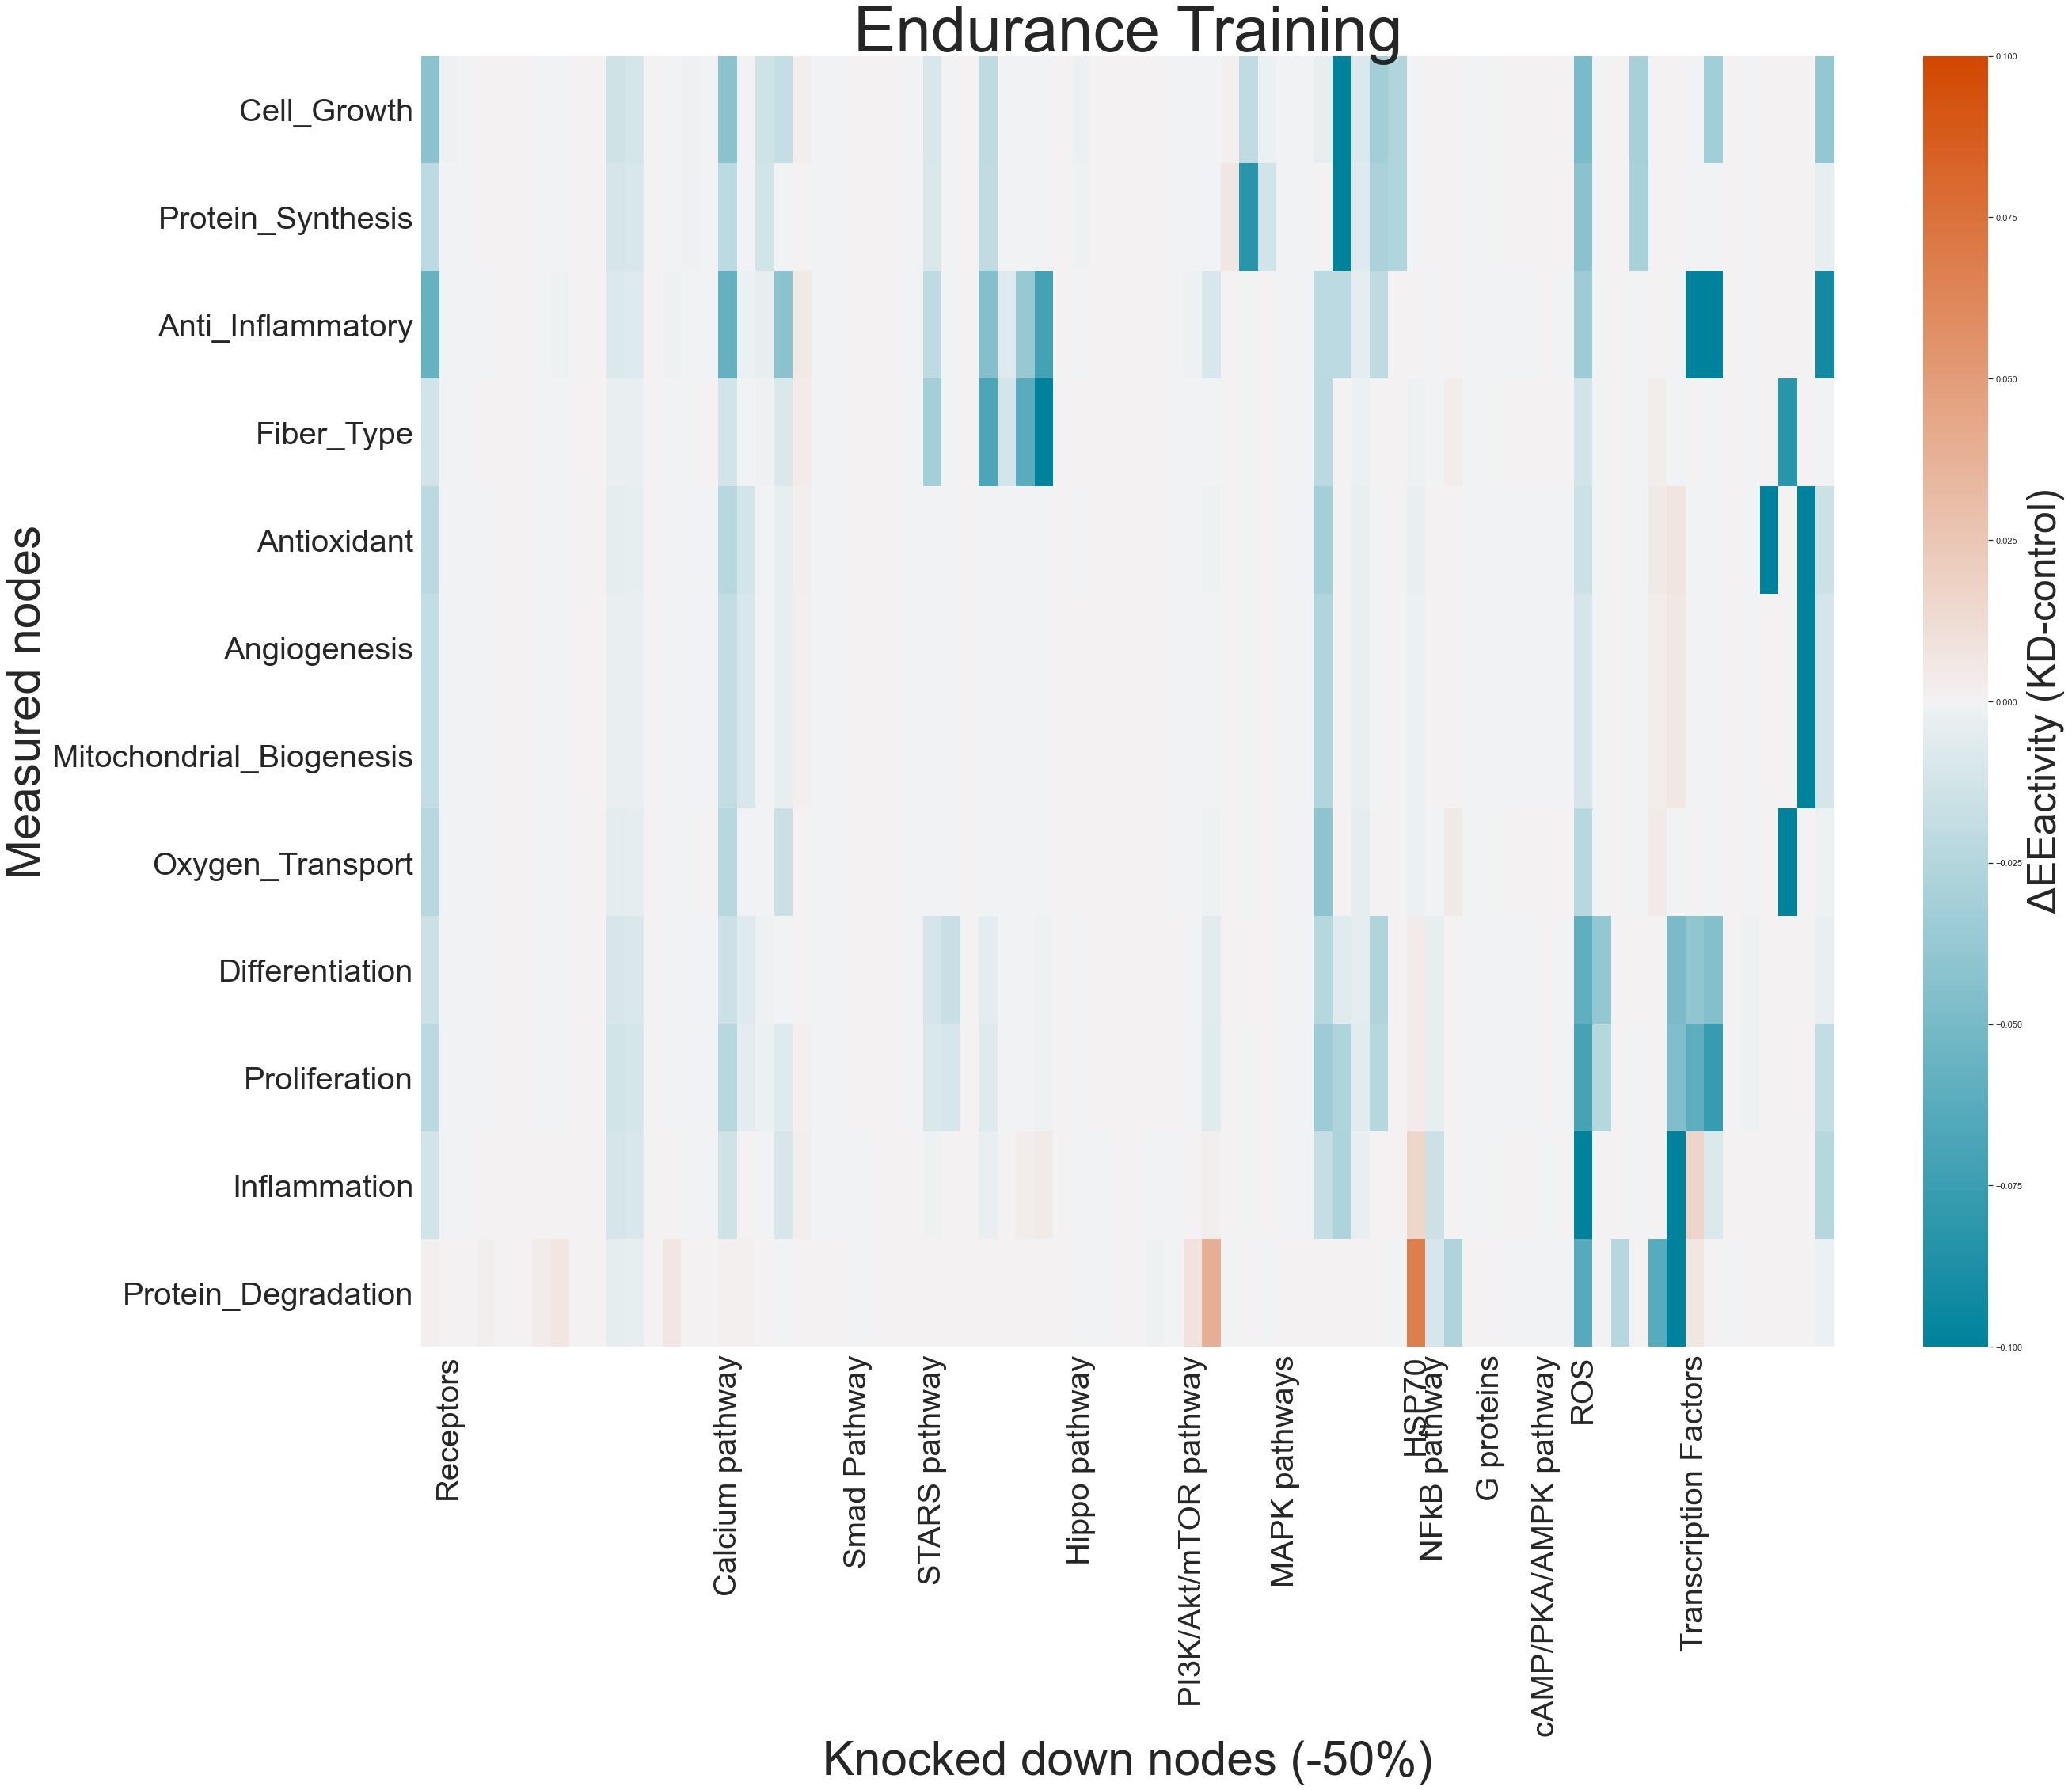

In [234]:

x=['',   'Receptors' , ' ', '' ,  '', ' ', '', ' ', '', '', '',  ' ', '', '', ' ',  ' ', 'Calcium pathway', '', '', '' , '', '', '', 'Smad Pathway', '', '', '', 'STARS pathway', '', '', '', '', '', '', '', 'Hippo pathway', '', '', '', '', '', 'PI3K/Akt/mTOR pathway','', '', '',  '', 'MAPK pathways',  '',  '', '', '', '', '', 'HSP70', 'NFkB pathway',  '', '', 'G proteins', '', '', 'cAMP/PKA/AMPK pathway', '',  'ROS','', '',  '', '', '',  'Transcription Factors', '', '', '','', '', '', '']
#x=['SAC',  'LPA', 'LPAR', 'B_AR',  'BMP', 'BMPR', 'IGF1', 'IGF1R', 'TGFB','TGFBR', 'TNFa',  'TNFR1', 'integrin','IRS1', 'FAK',  'cSrc', 'Ca', 'CAMK', 'PKC', 'calcineurin' , 'GSK3B', 'Shc', 'Crk', 'smad2_3', 'smad4', 'smad1_5_8', 'smad6_7', 'STARS', 'f_actin', 'g_actin', 'RhoA', 'LIMK1_2', 'ROCK', 'SRF', 'PA', 'MAP4K', 'MST1_2', 'SAV1', 'MOB1A_B', 'LATS1_2', 'NDR1_2', 'PI3K','Akt', 'TSC1_2', 'mTOR',  'Rheb', 'ras',  'raf',  'p38', 'JNK', 'MEK', 'ERK1_2', 'RSK', 'HSP70', 'IKK',  'HDAC', 'Ga12', 'Gai2', 'Gas', 'cAMP', 'AMPK', 'PKA',  'ROS','YAP_TAZ', 'myogenin',  'S6Ks', 'FoxO', 'NFkB',  'CREB', 'AP1', 'TIF_IA', 'TCF_Elk1','Nrf2', 'MEF2', 'PGC_1a', 'NFAT']


#y = ['Protein_Synthesis', 'Proliferation', 'Differentiation', 'Cell_Growth', 'Inflammation', 'Protein_Degradation', 'Anti_Inflammatory', 'Antioxidant', 'Angiogenesis', 'Mitochondrial_Biogenesis', 'Fiber_Type', 'Oxygen_Transport']
y=['Cell_Growth', 'Protein_Synthesis', 'Anti_Inflammatory', 'Fiber_Type', 'Antioxidant', 'Angiogenesis', 'Mitochondrial_Biogenesis',  'Oxygen_Transport', 'Differentiation', 'Proliferation', 'Inflammation', 'Protein_Degradation']


matrixe2 = np.zeros((99,12))
matrixe2 = matrixEEphenotype
matrixe2_T = matrixe2.transpose()
c = sns.diverging_palette(220, 20, s = 100, as_cmap=True)
p = sns.heatmap(matrixe2_T, center=0, xticklabels =x, yticklabels= y, cmap = c, vmin = -0.1, vmax = 0.1, cbar_kws={'label': '$\Delta$EEactivity (KD-control)'})
plt.tick_params(axis='x', labelsize=40, labelrotation=90)
plt.tick_params(axis='y', labelsize=40, labelrotation=0)
p.figure.axes[-1].yaxis.label.set_size(50)

sns.set(rc = {'figure.figsize':(40,30)}) 
p.set_ylabel('Measured nodes', fontsize = 60)
p.set_xlabel('Knocked down nodes (-50%)', fontsize = 60)
p.set_title("Endurance Training",fontsize = 80)
plt.savefig('sensitivityE_phenotype')

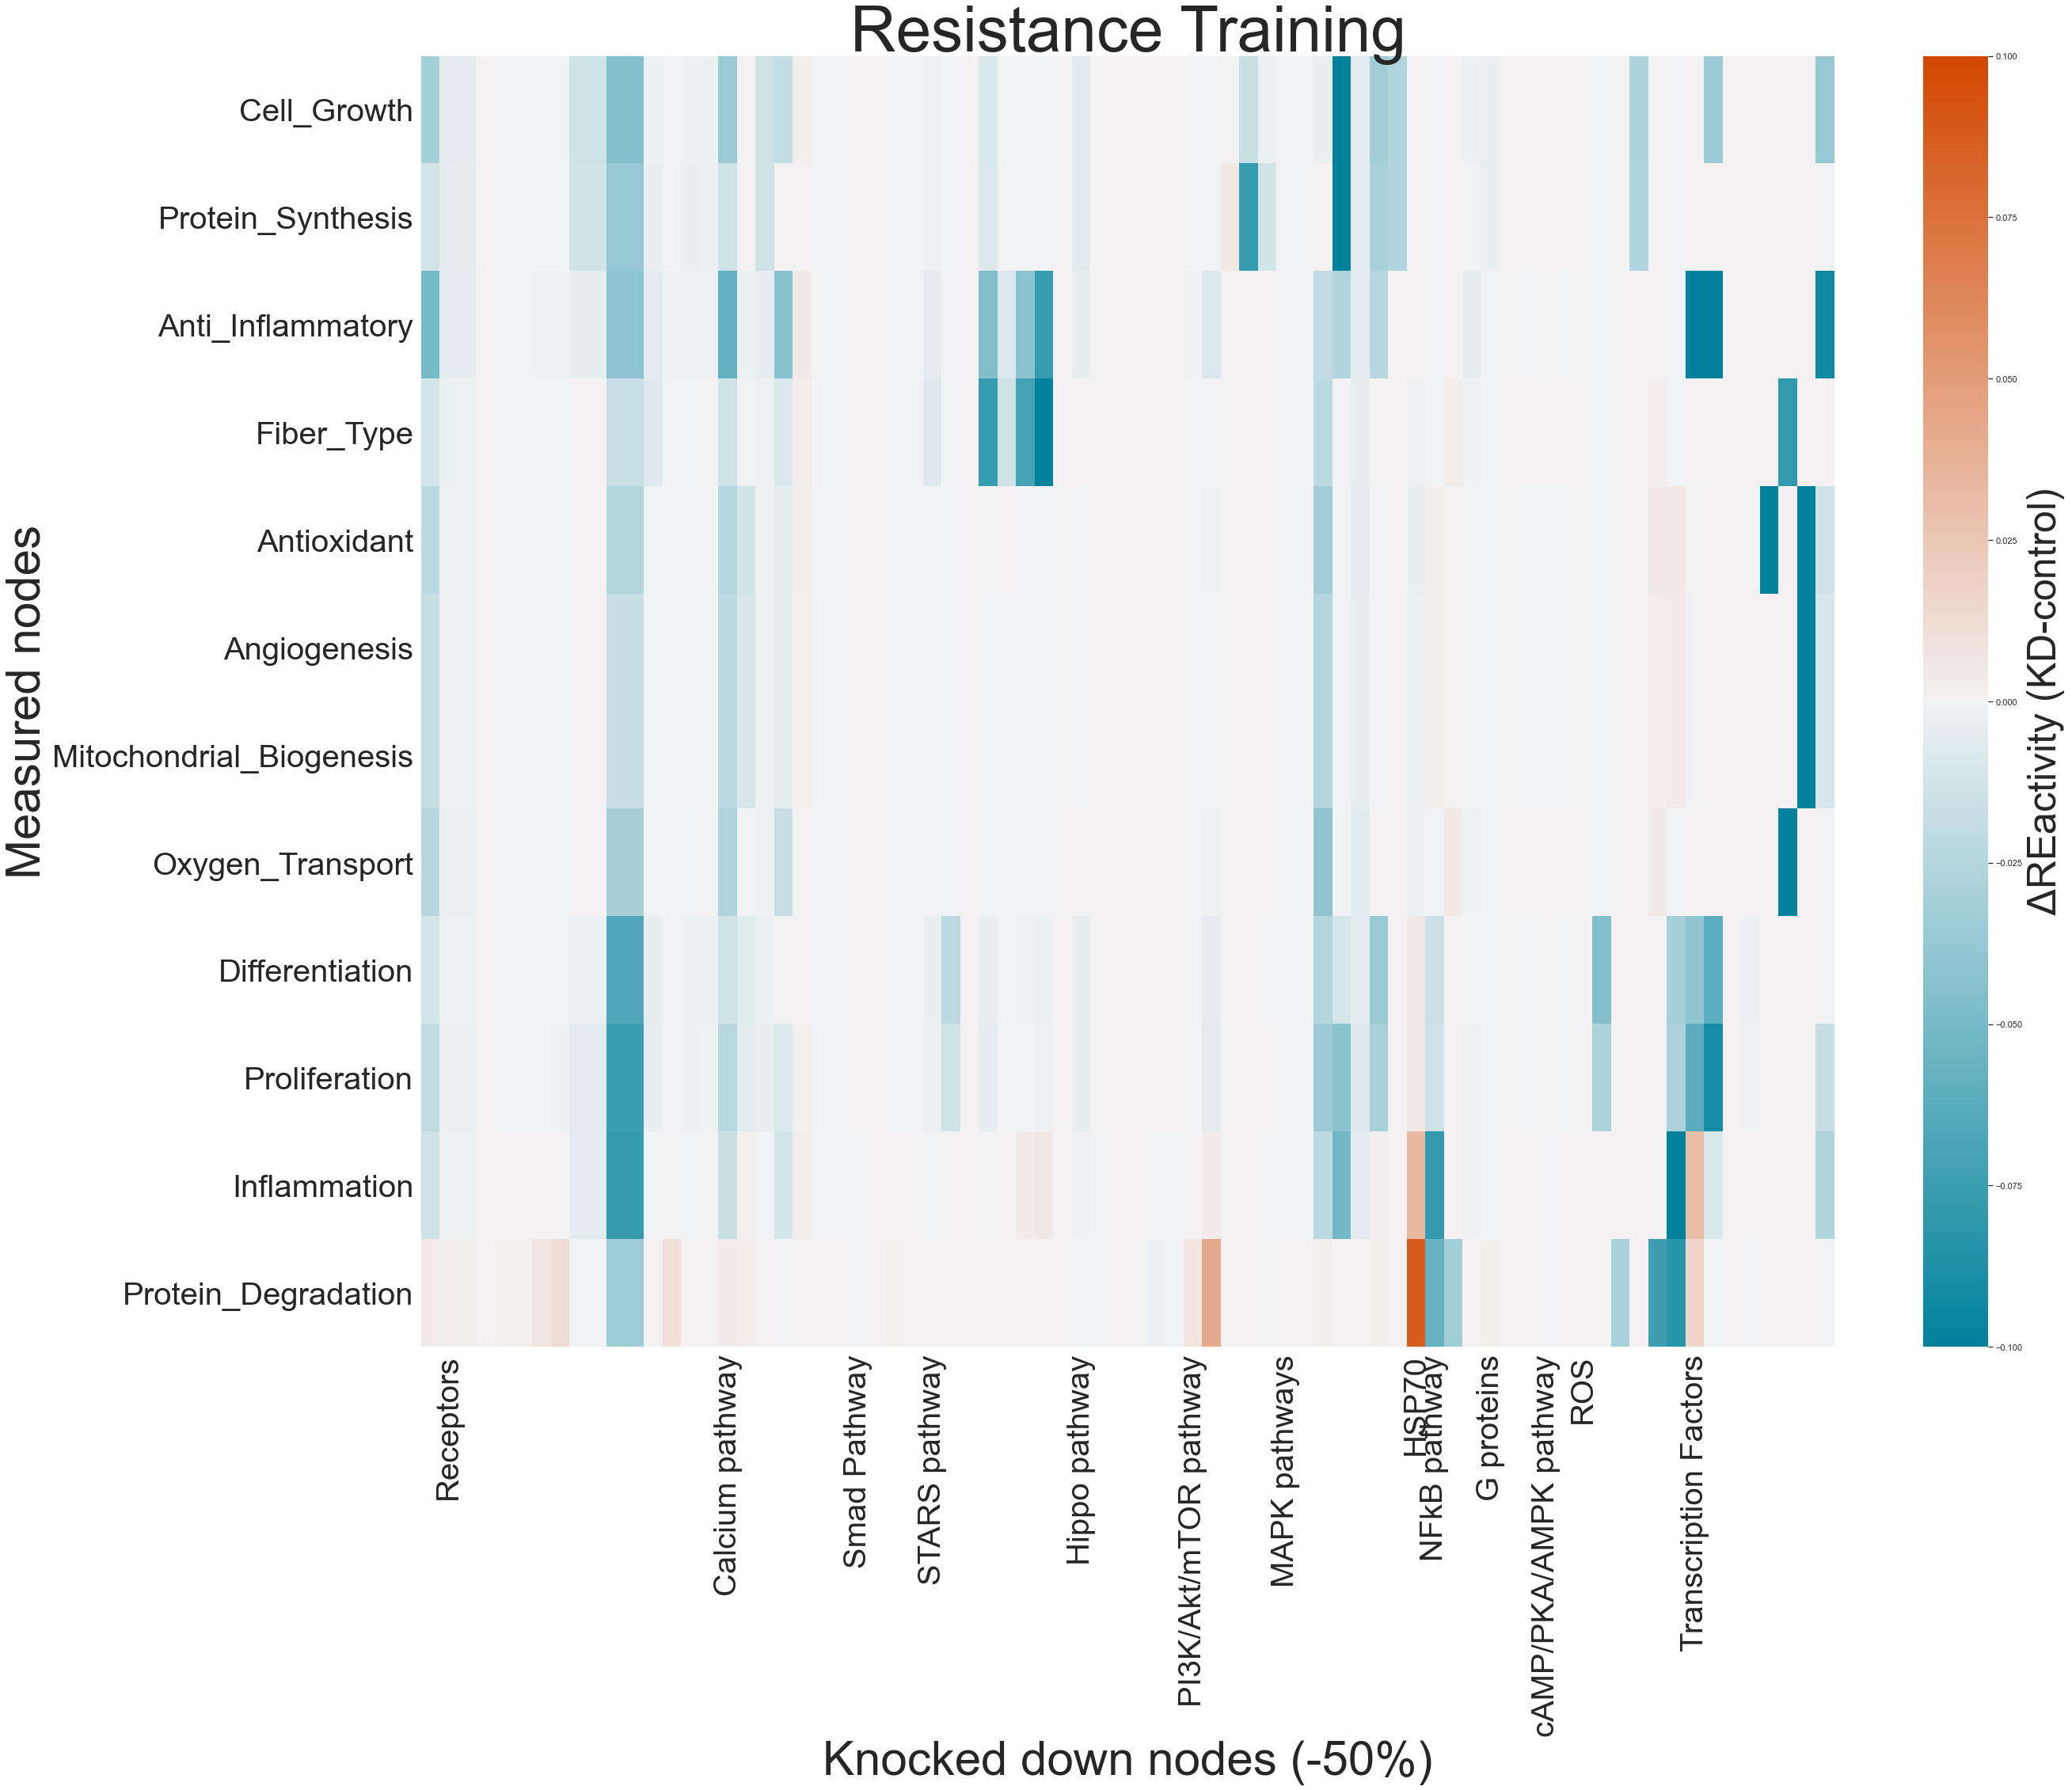

In [233]:
x=['',   'Receptors' , ' ', '' ,  '', ' ', '', ' ', '', '', '',  ' ', '', '', ' ',  ' ', 'Calcium pathway', '', '', '' , '', '', '', 'Smad Pathway', '', '', '', 'STARS pathway', '', '', '', '', '', '', '', 'Hippo pathway', '', '', '', '', '', 'PI3K/Akt/mTOR pathway','', '', '',  '', 'MAPK pathways',  '',  '', '', '', '', '', 'HSP70', 'NFkB pathway',  '', '', 'G proteins', '', '', 'cAMP/PKA/AMPK pathway', '',  'ROS','', '',  '', '', '',  'Transcription Factors', '', '', '','', '', '', '']

y=['Cell_Growth', 'Protein_Synthesis', 'Anti_Inflammatory', 'Fiber_Type', 'Antioxidant', 'Angiogenesis', 'Mitochondrial_Biogenesis',  'Oxygen_Transport', 'Differentiation', 'Proliferation', 'Inflammation', 'Protein_Degradation']
#x=['SAC',  'LPA', 'LPAR', 'B_AR',  'BMP', 'BMPR', 'IGF1', 'IGF1R', 'TGFB','TGFBR', 'TNFa',  'TNFR1', 'integrin','IRS1', 'FAK',  'cSrc', 'Ca', 'CAMK', 'PKC', 'calcineurin' , 'GSK3B', 'Shc', 'Crk', 'smad2_3', 'smad4', 'smad1_5_8', 'smad6_7', 'STARS', 'f_actin', 'g_actin', 'RhoA', 'LIMK1_2', 'ROCK', 'SRF', 'PA', 'MAP4K', 'MST1_2', 'SAV1', 'MOB1A_B', 'LATS1_2', 'NDR1_2', 'PI3K','Akt', 'TSC1_2', 'mTOR',  'Rheb', 'ras',  'raf',  'p38', 'JNK', 'MEK', 'ERK1_2', 'RSK', 'HSP70', 'IKK',  'HDAC', 'Ga12', 'Gai2', 'Gas', 'cAMP', 'AMPK', 'PKA',  'ROS','YAP_TAZ', 'myogenin',  'S6Ks', 'FoxO', 'NFkB',  'CREB', 'AP1', 'TIF_IA', 'TCF_Elk1','Nrf2', 'MEF2', 'PGC_1a', 'NFAT']




matrixdf2 = np.zeros((99,12))
matrixdf2 = matrixREphenotype
matrixdf2_T = matrixdf2.transpose()
c = sns.diverging_palette(220, 20, s = 100, as_cmap=True)
p = sns.heatmap(matrixdf2_T, center=0, xticklabels =x, yticklabels= y, cmap = c, vmin = -0.1, vmax = 0.1, cbar_kws={'label': '$\Delta$REactivity (KD-control)'})
plt.tick_params(axis='x', labelsize=40, labelrotation=90)
plt.tick_params(axis='y', labelsize=40, labelrotation=0)
p.figure.axes[-1].yaxis.label.set_size(50)

sns.set(rc = {'figure.figsize':(40,30)}) 
p.set_ylabel('Measured nodes', fontsize = 60)
p.set_xlabel('Knocked down nodes (-50%)', fontsize = 60)
p.set_title("Resistance Training",fontsize = 80)
plt.savefig('sensitivityR_phenotype')

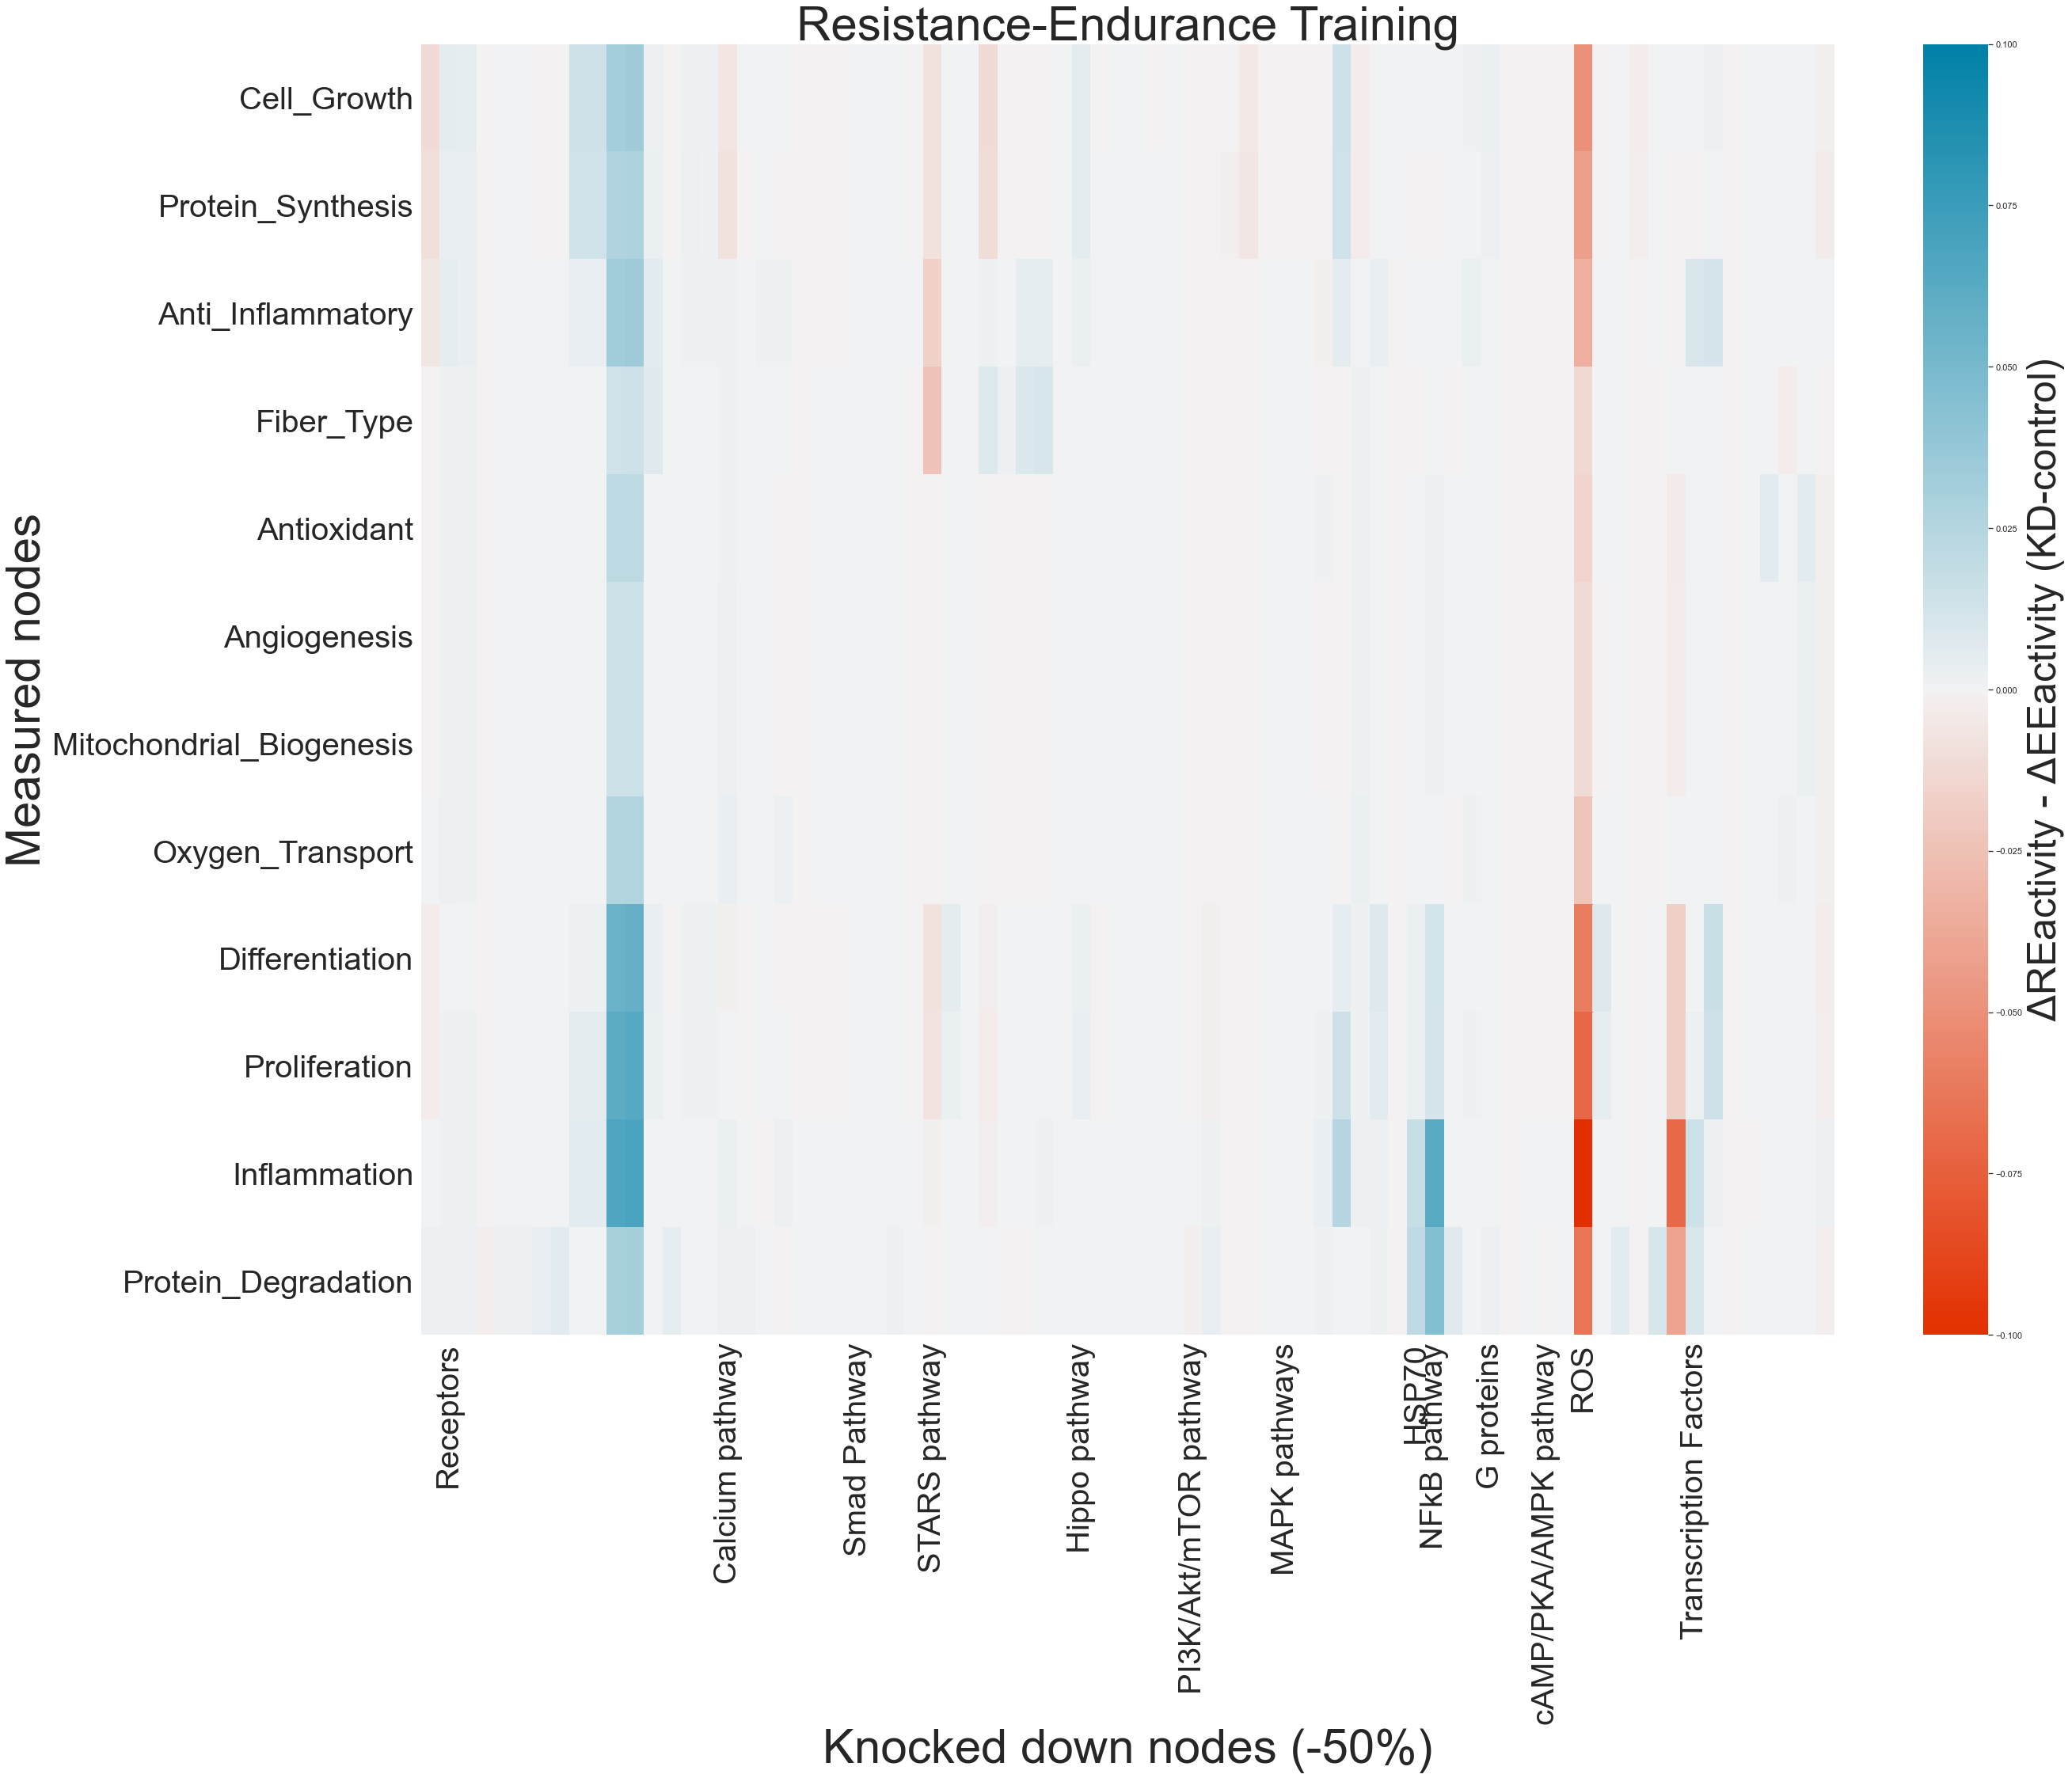

In [235]:
#x=['SAC',   'LPA/LPAR' , ' ', 'B_AR' ,  'BMP/BMPR', ' ', 'IGF1/IGF1R', ' ', 'TGFB/TGFBR', '', 'TNFa/TNFR1',  ' ', 'integrin pathway', '', ' ',  ' ', 'Calcium pathway', '', '', '' , '', '', '', 'Smad Pathway', '', '', '', 'STARS pathway', '', '', '', '', '', '', '', 'Hippo pathway', '', '', '', '', '', 'PI3K/Akt/mTOR pathway','', '', '',  '', 'MAPK pathways',  '',  '', '', '', '', '', 'HSP70', 'NFkB pathway',  '', 'Ga12', 'Gai2', 'Gas', '', 'cAMP/PKA/AMPK pathway', '',  'ROS','YAP_TAZ', 'myogenin',  'S6Ks', 'FoxO', 'NFkB',  'CREB', 'AP1', 'TIF_IA', 'TCF_Elk1','Nrf2', 'MEF2', 'PGC_1a', 'NFAT']
#x=['SAC',  'LPA', 'LPAR', 'B_AR',  'BMP', 'BMPR', 'IGF1', 'IGF1R', 'TGFB','TGFBR', 'TNFa',  'TNFR1', 'integrin','IRS1', 'FAK',  'cSrc', 'Ca', 'CAMK', 'PKC', 'calcineurin' , 'GSK3B', 'Shc', 'Crk', 'smad2_3', 'smad4', 'smad1_5_8', 'smad6_7', 'STARS', 'f_actin', 'g_actin', 'RhoA', 'LIMK1_2', 'ROCK', 'SRF', 'PA', 'MAP4K', 'MST1_2', 'SAV1', 'MOB1A_B', 'LATS1_2', 'NDR1_2', 'PI3K','Akt', 'TSC1_2', 'mTOR',  'Rheb', 'ras',  'raf',  'p38', 'JNK', 'MEK', 'ERK1_2', 'RSK', 'HSP70', 'IKK',  'HDAC', 'Ga12', 'Gai2', 'Gas', 'cAMP', 'AMPK', 'PKA',  'ROS','YAP_TAZ', 'myogenin',  'S6Ks', 'FoxO', 'NFkB',  'CREB', 'AP1', 'TIF_IA', 'TCF_Elk1','Nrf2', 'MEF2', 'PGC_1a', 'NFAT']
#x=['SAC',   'LPA/LPAR' , ' ', 'B_AR' ,  'BMP/BMPR', ' ', 'IGF1/IGF1R', ' ', 'TGFB/TGFBR', '', 'TNFa/TNFR1',  ' ', 'integrin pathway', '', ' ',  ' ', 'Calcium pathway', '', '', '' , '', '', '', 'Smad Pathway', '', '', '', 'STARS pathway', '', '', '', '', '', '', '', 'Hippo pathway', '', '', '', '', '', 'PI3K/Akt/mTOR pathway','', '', '',  '', 'MAPK pathways',  '',  '', '', '', '', '', 'HSP70', 'NFkB pathway',  '', 'Ga12', 'Gai2', 'Gas', '', 'cAMP/PKA/AMPK pathway', '',  'ROS','', '',  '', '', '',  'Transcription Factors', '', '', '','', '', '', '']

x=['',   'Receptors' , ' ', '' ,  '', ' ', '', ' ', '', '', '',  ' ', '', '', ' ',  ' ', 'Calcium pathway', '', '', '' , '', '', '', 'Smad Pathway', '', '', '', 'STARS pathway', '', '', '', '', '', '', '', 'Hippo pathway', '', '', '', '', '', 'PI3K/Akt/mTOR pathway','', '', '',  '', 'MAPK pathways',  '',  '', '', '', '', '', 'HSP70', 'NFkB pathway',  '', '', 'G proteins', '', '', 'cAMP/PKA/AMPK pathway', '',  'ROS','', '',  '', '', '',  'Transcription Factors', '', '', '','', '', '', '']



y=['Cell_Growth', 'Protein_Synthesis', 'Anti_Inflammatory', 'Fiber_Type', 'Antioxidant', 'Angiogenesis', 'Mitochondrial_Biogenesis',  'Oxygen_Transport', 'Differentiation', 'Proliferation', 'Inflammation', 'Protein_Degradation']


matrixdiff2abs = np.zeros((99,12))
matrixdiff2abs = np.absolute(matrixREphenotype)-np.absolute(matrixEEphenotype)
matrixdiff2_T = matrixdiff2abs.transpose()
c = sns.diverging_palette(15, 230, s = 100, as_cmap=True)
p = sns.heatmap(matrixdiff2_T, center=0, xticklabels =x, yticklabels= y, cmap = c, vmin = -0.1, vmax = 0.1, cbar_kws={'label': '$\Delta$REactivity - $\Delta$EEactivity (KD-control)'})
plt.tick_params(axis='x', labelsize=40, labelrotation=90)
plt.tick_params(axis='y', labelsize=40, labelrotation=0)
p.figure.axes[-1].yaxis.label.set_size(50)

sns.set(rc = {'figure.figsize':(40,30)}) 
p.set_ylabel('Measured nodes', fontsize = 60)
p.set_xlabel('Knocked down nodes (-50%)', fontsize = 60)
p.set_title("Resistance-Endurance Training",fontsize = 60)
plt.savefig('sensitivitydifference_phenotype')